In [ ]:
"""

Date : August 1, 2019

Author : Heather Landry Drexler

This script will develop plots for Supplemental Figure 5 of the nanoCOP manuscript. 

This script uses datasets created in the scripts nanoCOP_splice_df_datasets.ipynb and 
nanoCOP_termination_df_datasets.ipynb
                                            

"""


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import re
% matplotlib inline
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

import math

import pybedtools
from pybedtools import BedTool

import seaborn as sns
sns.set_style("white")

In [2]:
def get_first_last_introns(intron_info):
    
    first_intron_info = intron_info[intron_info['intron_order']=='first']
    first_intron_info = first_intron_info[['chrom','start','end','strand']].reset_index(drop=True)
    first_intron_info['position'] = 'first'
    
    last_intron_info = intron_info[intron_info['intron_order']=='last']
    last_intron_info = last_intron_info[['chrom','start','end','strand']].reset_index(drop=True)
    last_intron_info['position'] = 'last'

    first_last_intron_info = pd.concat([first_intron_info, last_intron_info])
    first_last_intron_info.columns = ['chrom','intron_start','intron_end','strand','position']
    first_last_intron_info = first_last_intron_info.drop_duplicates(subset=['chrom','intron_start','intron_end','strand']).reset_index(drop=True)
    
    return first_last_intron_info


# make a dataframe with the number of introns for every gene in the intron file
def get_intron_length(intron_df):

    # get length of all introns
    length = intron_df['intron_end']-intron_df['intron_start']
    intron_length_df = pd.concat([intron_df['name'],length],axis=1)
    intron_length_df.columns = ['name','intron_length']
    
    return intron_length_df

     

# make a dataframe with the transcript RPKM information for all introns
def get_RPKM_df(intron_df, featureCount_df):

    merge_df = pd.merge(intron_df,featureCount_df, how='left', on='gene')
    
    new_RPKM_df = pd.concat([merge_df['name'],merge_df['exon_RPKM']], axis=1)
    new_RPKM_df.columns = ['name','transcript_RPKM']
    
    return new_RPKM_df

 
# function to label missing gene names with transcript names
def name_missing_genes(row):
    if pd.isnull(row['gene']):
        return (row['transcript'])

    else:
        return (row['gene'])


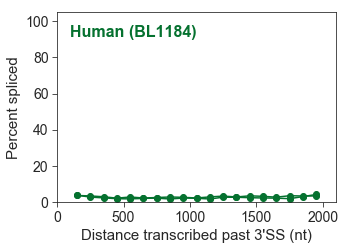

In [134]:
# SUPPLEMENTAL FIGURE 5A - distance transcribed before splicing plot BL1184

# read in files
BL1184_1_splice_df = pd.read_table('/path/to/BL1184_1_hg38_medIntrons_discarded_splice_df.txt', header=0)
BL1184_2_splice_df = pd.read_table('/path/to/BL1184_2_hg38_medIntrons_discarded_splice_df.txt', header=0)


fig, ax = plt.subplots(figsize=(5,3.5))


######### set variables for plot #########
window = 100
plot_min = 100
plot_max = 2000      


######### get info for each sample - replicate 1 #########
samples=['BL1184_1']

plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window)-1,int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        spliced_count = splicedf_spliced
        unspliced_count = splicedf_unspliced
        plot_list.append([plot_range_high,name,spliced_count,unspliced_count,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','spliced_count','unspliced_count','count','percentSpliced']
rep1_plot_df = plot_df.copy()
rep1_N = np.sum(plot_df['count'])

######### get statistics for Human #########
mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

mean_plot_df = pd.DataFrame(mean)
mean_plot_df.columns = ['range','mean']
mean_plot_df['stdev'] = stdev

######### plot mean and standard deviation for Human #########

x = mean_plot_df['range'].values
y = mean_plot_df['mean'].values
err = mean_plot_df['stdev'].values

ax = plt.plot(x, y, color=sns.color_palette("Greens")[5])
plt.fill_between(x, y-err, y+err, facecolor=sns.color_palette("Greens")[4], interpolate=True, alpha=0.25)
plt.scatter(x, y, color=sns.color_palette("Greens")[5])



######### get info for each sample - replicate 2 #########
samples=['BL1184_2']

plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window)-1,int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        spliced_count = splicedf_spliced
        unspliced_count = splicedf_unspliced
        plot_list.append([plot_range_high,name,spliced_count,unspliced_count,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','spliced_count','unspliced_count','count','percentSpliced']
rep2_plot_df = plot_df.copy()
rep2_N = np.sum(plot_df['count'])

######### get statistics for Human #########
mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

mean_plot_df = pd.DataFrame(mean)
mean_plot_df.columns = ['range','mean']
mean_plot_df['stdev'] = stdev

######### plot mean and standard deviation for Human #########

x = mean_plot_df['range'].values
y = mean_plot_df['mean'].values
err = mean_plot_df['stdev'].values

ax = plt.plot(x, y, color=sns.color_palette("Greens")[5])
plt.fill_between(x, y-err, y+err, facecolor=sns.color_palette("Greens")[4], interpolate=True, alpha=0.25)
plt.scatter(x, y, color=sns.color_palette("Greens")[5])


plt.ylabel("Percent spliced", fontsize=15)
plt.xlabel("Distance transcribed past 3'SS (nt)", fontsize=15)
#plt.suptitle("Percent Spliced by Distance Transcribed", fontsize=15, y=0.95)
plt.text(100, 98, 'Human (BL1184)', horizontalalignment='left', verticalalignment='top', fontsize=16, weight='bold', color=sns.color_palette("Greens")[5])

plt.xticks([0,500,1000,1500,2000], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.xlim(0,2100)
plt.ylim(0,105)

plt.savefig('/path/to/Supplemental_Figure_5A_BL1184_distance_spliced_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [135]:
print(rep1_N+rep2_N)

76245


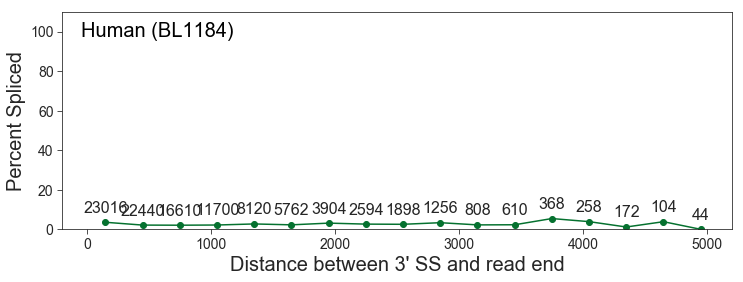

In [136]:
# SUPPLEMENTAL FIGURE 5B - BL1184 extended distance transcribed before splicing plots

# read in file
BL1184_1_minimap2_splice_df = pd.read_table('/path/to/BL1184_1_hg38_medIntrons_discarded_splice_df.txt', header=0)
BL1184_2_minimap2_splice_df = pd.read_table('/path/to/BL1184_2_hg38_medIntrons_discarded_splice_df.txt', header=0)

######### set variables for plot #########
window = 300
plot_min = 0
plot_max = 5100      

samples=['BL1184_1','BL1184_2']

######### get info for each sample #########
plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_minimap2_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window-1),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,splicedf_spliced,splicedf_unspliced,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','spliced_count','unspliced_count','percentSpliced']

######### get statistics for all samples #########
total = []

for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    sum_spliced = float(np.sum(plot_df[plot_df['range']==plot_range_high]['spliced_count']))
    sum_unspliced = float(np.sum(plot_df[plot_df['range']==plot_range_high]['unspliced_count']))
    count = sum_spliced + sum_unspliced
    percentSpliced = sum_spliced / (sum_spliced + sum_unspliced) * 100
    total.append([int(plot_range_middle), count, percentSpliced])

sum_plot_df = pd.DataFrame(total)
sum_plot_df.columns = ['range','count','percentSpliced']


######### plot mean and standard deviation for all samples #########

x = sum_plot_df['range'].values
y = sum_plot_df['percentSpliced'].values

fig, ax = plt.subplots(figsize=(12,4))

ax = plt.plot(x, y, color=sns.color_palette("Greens")[5])
plt.scatter(x, y, color=sns.color_palette("Greens")[5])

plt.ylabel("Percent Spliced", fontsize=20)
plt.xlabel("Distance between 3' SS and read end", fontsize=20)
plt.text(-50, 105, 'Human (BL1184)', horizontalalignment='left', verticalalignment='top', fontsize=20, color='black')

count = sum_plot_df['count'].values 
for i in range(0,len(x)):
    plt.annotate(int(count[i]),xy=(x[i],y[i]+5),fontsize=16,horizontalalignment='center')

plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.xlim(-200,5200)
plt.ylim(0,110)

plt.savefig('/path/to/Supplemental_Figure_5B_BL1184_distance_spliced_5kb_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()

/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


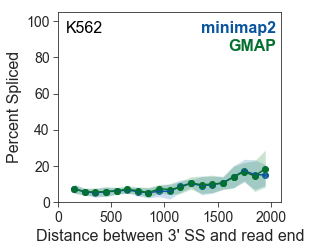

In [3]:
# SUPPLEMENTAL FIGURE 5C - distance transcribed before splicing plot GMAP vs. minimap2

# read in files
K562_1_minimap2_splice_df = pd.read_table('/path/to/K562_1_hg38_medIntrons_discarded_splice_df.txt', header=0)
K562_2_minimap2_splice_df = pd.read_table('/path/to/K562_2_hg38_medIntrons_discarded_splice_df.txt', header=0)
K562_3_minimap2_splice_df = pd.read_table('/path/to/K562_3_hg38_medIntrons_discarded_splice_df.txt', header=0)
K562_4_minimap2_splice_df = pd.read_table('/path/to/K562_4_hg38_medIntrons_discarded_splice_df.txt', header=0)
K562_5a_minimap2_splice_df = pd.read_table('/path/to/K562_5a_hg38_medIntrons_discarded_splice_df.txt', header=0)
K562_5b_minimap2_splice_df = pd.read_table('/path/to/K562_5b_hg38_medIntrons_discarded_splice_df.txt', header=0)
K562_5_minimap2_splice_df = pd.concat([K562_5a_minimap2_splice_df,K562_5b_minimap2_splice_df],axis=0)

K562_1_GMAP_splice_df = pd.read_table('/path/to/GMAP/K562_1_GMAP_splice_df.txt', header=0)
K562_2_GMAP_splice_df = pd.read_table('/path/to/GMAP/K562_2_GMAP_splice_df.txt', header=0)
K562_3_GMAP_splice_df = pd.read_table('/path/to/GMAP/K562_3_GMAP_splice_df.txt', header=0)
K562_4_GMAP_splice_df = pd.read_table('/path/to/GMAP/K562_4_GMAP_splice_df.txt', header=0)
K562_5a_GMAP_splice_df = pd.read_table('/path/to/GMAP/K562_5a_GMAP_splice_df.txt', header=0)
K562_5b_GMAP_splice_df = pd.read_table('/path/to/GMAP/K562_5b_GMAP_splice_df.txt', header=0)
K562_5_GMAP_splice_df = pd.concat([K562_5a_GMAP_splice_df,K562_5b_GMAP_splice_df],axis=0)


######### set variables for plot #########
window = 100
plot_min = 100
plot_max = 2000      

samples=['K562_1','K562_2','K562_3','K562_4','K562_5']

######### get info for each sample #########

# minimap2 alignments
minimap2_plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_minimap2_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window-1),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        minimap2_plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

minimap2_plot_df = pd.DataFrame(minimap2_plot_list)
minimap2_plot_df.columns = ['range','name','count','percentSpliced']

# GMAP alignments
GMAP_plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_GMAP_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window-1),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        GMAP_plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

GMAP_plot_df = pd.DataFrame(GMAP_plot_list)
GMAP_plot_df.columns = ['range','name','count','percentSpliced']


######### get statistics for all samples #########
minimap2_mean = []
minimap2_stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    minimap2_mean.append([int(plot_range_middle), np.mean(minimap2_plot_df[minimap2_plot_df['range']==plot_range_high]['percentSpliced'])])
    minimap2_stdev.append(np.std(minimap2_plot_df[minimap2_plot_df['range']==plot_range_high]['percentSpliced']))    

minimap2_mean_plot_df = pd.DataFrame(minimap2_mean)
minimap2_mean_plot_df.columns = ['range','mean']
minimap2_mean_plot_df['stdev'] = minimap2_stdev

GMAP_mean = []
GMAP_stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    GMAP_mean.append([int(plot_range_middle), np.mean(GMAP_plot_df[GMAP_plot_df['range']==plot_range_high]['percentSpliced'])])
    GMAP_stdev.append(np.std(GMAP_plot_df[GMAP_plot_df['range']==plot_range_high]['percentSpliced']))    

GMAP_mean_plot_df = pd.DataFrame(GMAP_mean)
GMAP_mean_plot_df.columns = ['range','mean']
GMAP_mean_plot_df['stdev'] = GMAP_stdev

######### plot mean and standard deviation for all samples #########


fig = plt.subplots(figsize=(4,3.5))

x = minimap2_mean_plot_df['range'].values
y = minimap2_mean_plot_df['mean'].values
err = minimap2_mean_plot_df['stdev'].values

plt.plot(x, y, color=sns.color_palette("Blues")[5])
plt.fill_between(x, y-err, y+err, facecolor=sns.color_palette("Blues")[4], interpolate=True, alpha=0.25)
plt.scatter(x, y, color=sns.color_palette("Blues")[5])

x = GMAP_mean_plot_df['range'].values
y = GMAP_mean_plot_df['mean'].values
err = GMAP_mean_plot_df['stdev'].values

plt.plot(x, y, color=sns.color_palette("Greens")[5])
plt.fill_between(x, y-err, y+err, facecolor=sns.color_palette("Greens")[4], interpolate=True, alpha=0.25)
plt.scatter(x, y, color=sns.color_palette("Greens")[5])


plt.ylabel("Percent Spliced", fontsize=16)
plt.xlabel("Distance between 3' SS and read end", fontsize=16)
#plt.suptitle("Percent Spliced by Distance Transcribed", fontsize=15, y=0.95)

plt.text(2050, 100, 'minimap2', horizontalalignment='right', verticalalignment='top', fontsize=16, weight='bold', color=sns.color_palette("Blues")[5])
plt.text(2050, 90, 'GMAP', horizontalalignment='right', verticalalignment='top', fontsize=16, weight='bold', color=sns.color_palette("Greens")[5])
plt.text(75, 100, 'K562', horizontalalignment='left', verticalalignment='top', fontsize=16, color='black')

plt.xticks([0,500,1000,1500,2000], fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.xlim(0,2100)
plt.ylim(0,105)

plt.savefig('/path/to/Supplemental_Figure_5C_K562_minimap2_GMAP_percent_spliced_by_distance.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [8]:
minimap2_plot_df.to_csv('/path/to/human_distance_transcribed_minimap2_plot_df', sep='\t', header=True, index=False)
GMAP_plot_df.to_csv('/path/to/human_distance_transcribed_gmap_plot_df', sep='\t', header=True, index=False)

/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


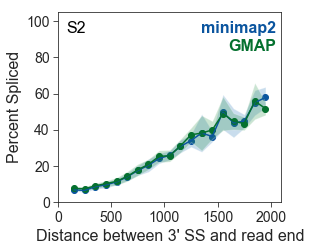

In [9]:
### S2 ###

# read in files
S2_1_minimap2_splice_df = pd.read_table('/path/to/S2_1_dm6_medIntrons_discarded_splice_df.txt', header=0)
S2_2_minimap2_splice_df = pd.read_table('/path/to/S2_2_dm6_medIntrons_discarded_splice_df.txt', header=0)
S2_3_minimap2_splice_df = pd.read_table('/path/to/S2_3_dm6_medIntrons_discarded_splice_df.txt', header=0)

S2_1_GMAP_splice_df = pd.read_table('/path/to/GMAP/S2_1_GMAP_splice_df.txt', header=0)
S2_2_GMAP_splice_df = pd.read_table('/path/to/GMAP/S2_2_GMAP_splice_df.txt', header=0)
S2_3_GMAP_splice_df = pd.read_table('/path/to/GMAP/S2_3_GMAP_splice_df.txt', header=0)


######### set variables for plot #########
window = 100
plot_min = 100
plot_max = 2000      

samples=['S2_1','S2_2','S2_3']

######### get info for each sample #########

# minimap2 alignments
minimap2_plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_minimap2_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window-1),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        minimap2_plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

minimap2_plot_df = pd.DataFrame(minimap2_plot_list)
minimap2_plot_df.columns = ['range','name','count','percentSpliced']

# GMAP alignments
GMAP_plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_GMAP_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window-1),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        GMAP_plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

GMAP_plot_df = pd.DataFrame(GMAP_plot_list)
GMAP_plot_df.columns = ['range','name','count','percentSpliced']


######### get statistics for all samples #########
minimap2_mean = []
minimap2_stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    minimap2_mean.append([int(plot_range_middle), np.mean(minimap2_plot_df[minimap2_plot_df['range']==plot_range_high]['percentSpliced'])])
    minimap2_stdev.append(np.std(minimap2_plot_df[minimap2_plot_df['range']==plot_range_high]['percentSpliced']))    

minimap2_mean_plot_df = pd.DataFrame(minimap2_mean)
minimap2_mean_plot_df.columns = ['range','mean']
minimap2_mean_plot_df['stdev'] = minimap2_stdev

GMAP_mean = []
GMAP_stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    GMAP_mean.append([int(plot_range_middle), np.mean(GMAP_plot_df[GMAP_plot_df['range']==plot_range_high]['percentSpliced'])])
    GMAP_stdev.append(np.std(GMAP_plot_df[GMAP_plot_df['range']==plot_range_high]['percentSpliced']))    

GMAP_mean_plot_df = pd.DataFrame(GMAP_mean)
GMAP_mean_plot_df.columns = ['range','mean']
GMAP_mean_plot_df['stdev'] = GMAP_stdev

######### plot mean and standard deviation for all samples #########


fig = plt.subplots(figsize=(4,3.5))

x = minimap2_mean_plot_df['range'].values
y = minimap2_mean_plot_df['mean'].values
err = minimap2_mean_plot_df['stdev'].values

plt.plot(x, y, color=sns.color_palette("Blues")[5])
plt.fill_between(x, y-err, y+err, facecolor=sns.color_palette("Blues")[4], interpolate=True, alpha=0.25)
plt.scatter(x, y, color=sns.color_palette("Blues")[5])

x = GMAP_mean_plot_df['range'].values
y = GMAP_mean_plot_df['mean'].values
err = GMAP_mean_plot_df['stdev'].values

plt.plot(x, y, color=sns.color_palette("Greens")[5])
plt.fill_between(x, y-err, y+err, facecolor=sns.color_palette("Greens")[4], interpolate=True, alpha=0.25)
plt.scatter(x, y, color=sns.color_palette("Greens")[5])


plt.ylabel("Percent Spliced", fontsize=16)
plt.xlabel("Distance between 3' SS and read end", fontsize=16)
#plt.suptitle("Percent Spliced by Distance Transcribed", fontsize=15, y=0.95)

plt.text(2050, 100, 'minimap2', horizontalalignment='right', verticalalignment='top', fontsize=16, weight='bold', color=sns.color_palette("Blues")[5])
plt.text(2050, 90, 'GMAP', horizontalalignment='right', verticalalignment='top', fontsize=16, weight='bold', color=sns.color_palette("Greens")[5])
plt.text(75, 100, 'S2', horizontalalignment='left', verticalalignment='top', fontsize=16, color='black')

plt.xticks([0,500,1000,1500,2000], fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.xlim(0,2100)
plt.ylim(0,105)

plt.savefig('/path/to/Supplemental_Figure_5C_S2_minimap2_GMAP_percent_spliced_by_distance.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [10]:
minimap2_plot_df.to_csv('/path/to/drosophila_distance_transcribed_minimap2_plot_df', sep='\t', header=True, index=False)
GMAP_plot_df.to_csv('/path/to/drosophila_distance_transcribed_gmap_plot_df', sep='\t', header=True, index=False)

/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


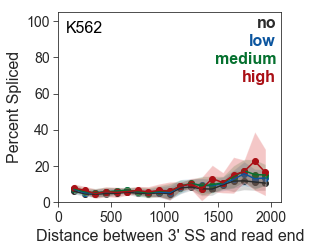

In [31]:
# SUPPLEMENTAL FIGURE 5D - distance transcribed before splicing plot intron stringencies

### K562 ###

# read in files
K562_1_minimap2_no_splice_df = pd.read_table('/path/to/K562_1_hg38_allIntrons_discarded_splice_df.txt', header=0)
K562_2_minimap2_no_splice_df = pd.read_table('/path/to/K562_2_hg38_allIntrons_discarded_splice_df.txt', header=0)
K562_3_minimap2_no_splice_df = pd.read_table('/path/to/K562_3_hg38_allIntrons_discarded_splice_df.txt', header=0)
K562_5a_minimap2_no_splice_df = pd.read_table('/path/to/K562_5a_hg38_allIntrons_discarded_splice_df.txt', header=0)
K562_4_minimap2_no_splice_df = pd.read_table('/path/to/K562_4_hg38_allIntrons_discarded_splice_df.txt', header=0)
K562_5b_minimap2_no_splice_df = pd.read_table('/path/to/K562_5b_hg38_allIntrons_discarded_splice_df.txt', header=0)
K562_5_minimap2_no_splice_df = pd.concat([K562_5a_minimap2_no_splice_df,K562_5b_minimap2_no_splice_df],axis=0)

K562_1_minimap2_low_splice_df = pd.read_table('/path/to/K562_1_hg38_lowIntrons_discarded_splice_df.txt', header=0)
K562_2_minimap2_low_splice_df = pd.read_table('/path/to/K562_2_hg38_lowIntrons_discarded_splice_df.txt', header=0)
K562_3_minimap2_low_splice_df = pd.read_table('/path/to/K562_3_hg38_lowIntrons_discarded_splice_df.txt', header=0)
K562_5a_minimap2_low_splice_df = pd.read_table('/path/to/K562_5a_hg38_lowIntrons_discarded_splice_df.txt', header=0)
K562_4_minimap2_low_splice_df = pd.read_table('/path/to/K562_4_hg38_lowIntrons_discarded_splice_df.txt', header=0)
K562_5b_minimap2_low_splice_df = pd.read_table('/path/to/K562_5b_hg38_lowIntrons_discarded_splice_df.txt', header=0)
K562_5_minimap2_low_splice_df = pd.concat([K562_5a_minimap2_low_splice_df,K562_5b_minimap2_low_splice_df],axis=0)

K562_1_minimap2_medium_splice_df = pd.read_table('/path/to/K562_1_hg38_medIntrons_discarded_splice_df.txt', header=0)
K562_2_minimap2_medium_splice_df = pd.read_table('/path/to/K562_2_hg38_medIntrons_discarded_splice_df.txt', header=0)
K562_3_minimap2_medium_splice_df = pd.read_table('/path/to/K562_3_hg38_medIntrons_discarded_splice_df.txt', header=0)
K562_5a_minimap2_medium_splice_df = pd.read_table('/path/to/K562_5a_hg38_medIntrons_discarded_splice_df.txt', header=0)
K562_4_minimap2_medium_splice_df = pd.read_table('/path/to/K562_4_hg38_medIntrons_discarded_splice_df.txt', header=0)
K562_5b_minimap2_medium_splice_df = pd.read_table('/path/to/K562_5b_hg38_medIntrons_discarded_splice_df.txt', header=0)
K562_5_minimap2_medium_splice_df = pd.concat([K562_5a_minimap2_medium_splice_df,K562_5b_minimap2_medium_splice_df],axis=0)

K562_1_minimap2_high_splice_df = pd.read_table('/path/to/K562_1_hg38_highIntrons_discarded_splice_df.txt', header=0)
K562_2_minimap2_high_splice_df = pd.read_table('/path/to/K562_2_hg38_highIntrons_discarded_splice_df.txt', header=0)
K562_3_minimap2_high_splice_df = pd.read_table('/path/to/K562_3_hg38_highIntrons_discarded_splice_df.txt', header=0)
K562_5a_minimap2_high_splice_df = pd.read_table('/path/to/K562_5a_hg38_highIntrons_discarded_splice_df.txt', header=0)
K562_4_minimap2_high_splice_df = pd.read_table('/path/to/K562_4_hg38_highIntrons_discarded_splice_df.txt', header=0)
K562_5b_minimap2_high_splice_df = pd.read_table('/path/to/K562_5b_hg38_highIntrons_discarded_splice_df.txt', header=0)
K562_5_minimap2_high_splice_df = pd.concat([K562_5a_minimap2_high_splice_df,K562_5b_minimap2_high_splice_df],axis=0)


######### set variables for plot #########
window = 100
plot_min = 100
plot_max = 2000      

samples=['K562_1','K562_2','K562_3','K562_4','K562_5']

######### get info for each sample #########

# no stringency introns
no_plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_minimap2_no_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window-1),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        no_plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

no_plot_df = pd.DataFrame(no_plot_list)
no_plot_df.columns = ['range','name','count','percentSpliced']

# low stringency introns
low_plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_minimap2_low_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window-1),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        low_plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

low_plot_df = pd.DataFrame(low_plot_list)
low_plot_df.columns = ['range','name','count','percentSpliced']

# medium stringency introns
medium_plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_minimap2_medium_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window-1),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        medium_plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

medium_plot_df = pd.DataFrame(medium_plot_list)
medium_plot_df.columns = ['range','name','count','percentSpliced']

# high stringency introns
high_plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_minimap2_high_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window-1),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        high_plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

high_plot_df = pd.DataFrame(high_plot_list)
high_plot_df.columns = ['range','name','count','percentSpliced']


######### get statistics for all samples #########
plot_df = no_plot_df.copy()
mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

no_mean_plot_df = pd.DataFrame(mean)
no_mean_plot_df.columns = ['range','mean']
no_mean_plot_df['stdev'] = stdev

plot_df = low_plot_df.copy()
mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

low_mean_plot_df = pd.DataFrame(mean)
low_mean_plot_df.columns = ['range','mean']
low_mean_plot_df['stdev'] = stdev

plot_df = medium_plot_df.copy()
mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

medium_mean_plot_df = pd.DataFrame(mean)
medium_mean_plot_df.columns = ['range','mean']
medium_mean_plot_df['stdev'] = stdev

plot_df = high_plot_df.copy()
mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

high_mean_plot_df = pd.DataFrame(mean)
high_mean_plot_df.columns = ['range','mean']
high_mean_plot_df['stdev'] = stdev

######### plot mean and standard deviation for all samples #########


fig = plt.subplots(figsize=(4,3.5))

x = no_mean_plot_df['range'].values
y = no_mean_plot_df['mean'].values
err = no_mean_plot_df['stdev'].values

plt.plot(x, y, color=sns.color_palette("Greys")[5])
plt.fill_between(x, y-err, y+err, facecolor=sns.color_palette("Greys")[4], interpolate=True, alpha=0.25)
plt.scatter(x, y, color=sns.color_palette("Greys")[5])

x = low_mean_plot_df['range'].values
y = low_mean_plot_df['mean'].values
err = low_mean_plot_df['stdev'].values

plt.plot(x, y, color=sns.color_palette("Blues")[5])
plt.fill_between(x, y-err, y+err, facecolor=sns.color_palette("Blues")[4], interpolate=True, alpha=0.25)
plt.scatter(x, y, color=sns.color_palette("Blues")[5])

x = medium_mean_plot_df['range'].values
y = medium_mean_plot_df['mean'].values
err = medium_mean_plot_df['stdev'].values

plt.plot(x, y, color=sns.color_palette("Greens")[5])
plt.fill_between(x, y-err, y+err, facecolor=sns.color_palette("Greens")[4], interpolate=True, alpha=0.25)
plt.scatter(x, y, color=sns.color_palette("Greens")[5])

x = high_mean_plot_df['range'].values
y = high_mean_plot_df['mean'].values
err = high_mean_plot_df['stdev'].values

plt.plot(x, y, color=sns.color_palette("Reds")[5])
plt.fill_between(x, y-err, y+err, facecolor=sns.color_palette("Reds")[4], interpolate=True, alpha=0.25)
plt.scatter(x, y, color=sns.color_palette("Reds")[5])

plt.ylabel("Percent Spliced", fontsize=16)
plt.xlabel("Distance between 3' SS and read end", fontsize=16)
#plt.suptitle("Percent Spliced by Distance Transcribed", fontsize=15, y=0.95)

plt.text(2050, 103, 'no', horizontalalignment='right', verticalalignment='top', fontsize=16, weight='bold', color=sns.color_palette("Greys")[5])
plt.text(2050, 93, 'low', horizontalalignment='right', verticalalignment='top', fontsize=16, weight='bold', color=sns.color_palette("Blues")[5])
plt.text(2050, 83, 'medium', horizontalalignment='right', verticalalignment='top', fontsize=16, weight='bold', color=sns.color_palette("Greens")[5])
plt.text(2050, 73, 'high', horizontalalignment='right', verticalalignment='top', fontsize=16, weight='bold', color=sns.color_palette("Reds")[5])
plt.text(75, 100, 'K562', horizontalalignment='left', verticalalignment='top', fontsize=16, color='black')

plt.xticks([0,500,1000,1500,2000], fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.xlim(0,2100)
plt.ylim(0,105)

plt.savefig('/path/to/Supplemental_Figure_5D_K562_intronStringencies_percent_spliced_by_distance.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [32]:
no_plot_df.to_csv('/path/to/human_distance_transcribed_noStringency_plot_df.txt', sep='\t', header=True, index=False)
low_plot_df.to_csv('/path/to/human_distance_transcribed_lowStringency_plot_df.txt', sep='\t', header=True, index=False)
medium_plot_df.to_csv('/path/to/human_distance_transcribed_mediumStringency_plot_df.txt', sep='\t', header=True, index=False)
high_plot_df.to_csv('/path/to/human_distance_transcribed_highStringency_plot_df.txt', sep='\t', header=True, index=False)

/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


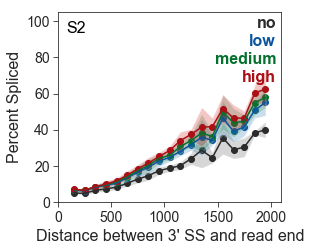

In [33]:
### S2 ###

# read in files
S2_1_minimap2_no_splice_df = pd.read_table('/path/to/S2_1_minimap2_noStringency_splice_df.txt', header=0)
S2_2_minimap2_no_splice_df = pd.read_table('/path/to/S2_2_minimap2_noStringency_splice_df.txt', header=0)
S2_3_minimap2_no_splice_df = pd.read_table('/path/to/S2_3_minimap2_noStringency_splice_df.txt', header=0)

S2_1_minimap2_low_splice_df = pd.read_table('/path/to/S2_1_minimap2_lowStringency_splice_df.txt', header=0)
S2_2_minimap2_low_splice_df = pd.read_table('/path/to/S2_2_minimap2_lowStringency_splice_df.txt', header=0)
S2_3_minimap2_low_splice_df = pd.read_table('/path/to/S2_3_minimap2_lowStringency_splice_df.txt', header=0)

S2_1_minimap2_medium_splice_df = pd.read_table('/path/to/S2_1_minimap2_mediumStringency_splice_df.txt', header=0)
S2_2_minimap2_medium_splice_df = pd.read_table('/path/to/S2_2_minimap2_mediumStringency_splice_df.txt', header=0)
S2_3_minimap2_medium_splice_df = pd.read_table('/path/to/S2_3_minimap2_mediumStringency_splice_df.txt', header=0)

S2_1_minimap2_high_splice_df = pd.read_table('/path/to/S2_1_minimap2_highStringency_splice_df.txt', header=0)
S2_2_minimap2_high_splice_df = pd.read_table('/path/to/S2_2_minimap2_highStringency_splice_df.txt', header=0)
S2_3_minimap2_high_splice_df = pd.read_table('/path/to/S2_3_minimap2_highStringency_splice_df.txt', header=0)

######### set variables for plot #########
window = 100
plot_min = 100
plot_max = 2000      

samples=['S2_1','S2_2','S2_3']

######### get info for each sample #########

# no stringency introns
no_plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_minimap2_no_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window-1),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        no_plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

no_plot_df = pd.DataFrame(no_plot_list)
no_plot_df.columns = ['range','name','count','percentSpliced']

# low stringency introns
low_plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_minimap2_low_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window-1),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        low_plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

low_plot_df = pd.DataFrame(low_plot_list)
low_plot_df.columns = ['range','name','count','percentSpliced']

# medium stringency introns
medium_plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_minimap2_medium_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window-1),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        medium_plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

medium_plot_df = pd.DataFrame(medium_plot_list)
medium_plot_df.columns = ['range','name','count','percentSpliced']

# high stringency introns
high_plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_minimap2_high_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window-1),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        high_plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

high_plot_df = pd.DataFrame(high_plot_list)
high_plot_df.columns = ['range','name','count','percentSpliced']


######### get statistics for all samples #########
plot_df = no_plot_df.copy()
mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

no_mean_plot_df = pd.DataFrame(mean)
no_mean_plot_df.columns = ['range','mean']
no_mean_plot_df['stdev'] = stdev

plot_df = low_plot_df.copy()
mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

low_mean_plot_df = pd.DataFrame(mean)
low_mean_plot_df.columns = ['range','mean']
low_mean_plot_df['stdev'] = stdev

plot_df = medium_plot_df.copy()
mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

medium_mean_plot_df = pd.DataFrame(mean)
medium_mean_plot_df.columns = ['range','mean']
medium_mean_plot_df['stdev'] = stdev

plot_df = high_plot_df.copy()
mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

high_mean_plot_df = pd.DataFrame(mean)
high_mean_plot_df.columns = ['range','mean']
high_mean_plot_df['stdev'] = stdev

######### plot mean and standard deviation for all samples #########


fig = plt.subplots(figsize=(4,3.5))

x = no_mean_plot_df['range'].values
y = no_mean_plot_df['mean'].values
err = no_mean_plot_df['stdev'].values

plt.plot(x, y, color=sns.color_palette("Greys")[5])
plt.fill_between(x, y-err, y+err, facecolor=sns.color_palette("Greys")[4], interpolate=True, alpha=0.25)
plt.scatter(x, y, color=sns.color_palette("Greys")[5])

x = low_mean_plot_df['range'].values
y = low_mean_plot_df['mean'].values
err = low_mean_plot_df['stdev'].values

plt.plot(x, y, color=sns.color_palette("Blues")[5])
plt.fill_between(x, y-err, y+err, facecolor=sns.color_palette("Blues")[4], interpolate=True, alpha=0.25)
plt.scatter(x, y, color=sns.color_palette("Blues")[5])

x = medium_mean_plot_df['range'].values
y = medium_mean_plot_df['mean'].values
err = medium_mean_plot_df['stdev'].values

plt.plot(x, y, color=sns.color_palette("Greens")[5])
plt.fill_between(x, y-err, y+err, facecolor=sns.color_palette("Greens")[4], interpolate=True, alpha=0.25)
plt.scatter(x, y, color=sns.color_palette("Greens")[5])

x = high_mean_plot_df['range'].values
y = high_mean_plot_df['mean'].values
err = high_mean_plot_df['stdev'].values

plt.plot(x, y, color=sns.color_palette("Reds")[5])
plt.fill_between(x, y-err, y+err, facecolor=sns.color_palette("Reds")[4], interpolate=True, alpha=0.25)
plt.scatter(x, y, color=sns.color_palette("Reds")[5])

plt.ylabel("Percent Spliced", fontsize=16)
plt.xlabel("Distance between 3' SS and read end", fontsize=16)
#plt.suptitle("Percent Spliced by Distance Transcribed", fontsize=15, y=0.95)

plt.text(2050, 103, 'no', horizontalalignment='right', verticalalignment='top', fontsize=16, weight='bold', color=sns.color_palette("Greys")[5])
plt.text(2050, 93, 'low', horizontalalignment='right', verticalalignment='top', fontsize=16, weight='bold', color=sns.color_palette("Blues")[5])
plt.text(2050, 83, 'medium', horizontalalignment='right', verticalalignment='top', fontsize=16, weight='bold', color=sns.color_palette("Greens")[5])
plt.text(2050, 73, 'high', horizontalalignment='right', verticalalignment='top', fontsize=16, weight='bold', color=sns.color_palette("Reds")[5])
plt.text(75, 100, 'S2', horizontalalignment='left', verticalalignment='top', fontsize=16, color='black')

plt.xticks([0,500,1000,1500,2000], fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.xlim(0,2100)
plt.ylim(0,105)

plt.savefig('/path/to/Supplemental_Figure_5D_S2_intronStringencies_percent_spliced_by_distance.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [34]:
no_plot_df.to_csv('/path/to/drosophila_distance_transcribed_noStringency_plot_df.txt', sep='\t', header=True, index=False)
low_plot_df.to_csv('/path/to/drosophila_distance_transcribed_lowStringency_plot_df.txt', sep='\t', header=True, index=False)
medium_plot_df.to_csv('/path/to/drosophila_distance_transcribed_mediumStringency_plot_df.txt', sep='\t', header=True, index=False)
high_plot_df.to_csv('/path/to/drosophila_distance_transcribed_highStringency_plot_df.txt', sep='\t', header=True, index=False)

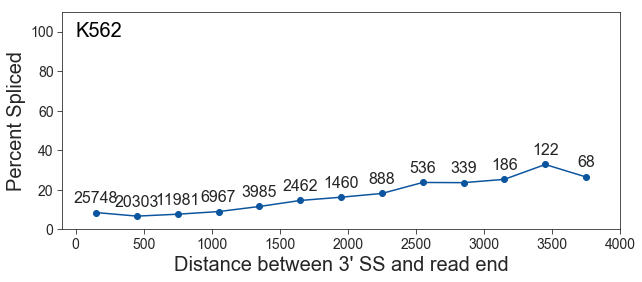

In [13]:
# SUPPLEMENTAL FIGURE 5E - K562 extended distance transcribed before splicing plots

# read in file
K562_1_minimap2_splice_df = pd.read_table('/path/to/K562_1_hg38_medIntrons_discarded_splice_df.txt', header=0)
K562_2_minimap2_splice_df = pd.read_table('/path/to/K562_2_hg38_medIntrons_discarded_splice_df.txt', header=0)
K562_3_minimap2_splice_df = pd.read_table('/path/to/K562_3_hg38_medIntrons_discarded_splice_df.txt', header=0)
K562_4_minimap2_splice_df = pd.read_table('/path/to/K562_4_hg38_medIntrons_discarded_splice_df.txt', header=0)
K562_5a_minimap2_splice_df = pd.read_table('/path/to/K562_5a_hg38_medIntrons_discarded_splice_df.txt', header=0)
K562_5b_minimap2_splice_df = pd.read_table('/path/to/K562_5b_hg38_medIntrons_discarded_splice_df.txt', header=0)

######### set variables for plot #########
window = 300
plot_min = 0
plot_max = 3900      

samples=['K562_1','K562_2','K562_3','K562_4','K562_5a','K562_5b']

######### get info for each sample #########
plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_minimap2_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window-1),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,splicedf_spliced,splicedf_unspliced,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','spliced_count','unspliced_count','percentSpliced']

######### get statistics for all samples #########
total = []

for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    sum_spliced = float(np.sum(plot_df[plot_df['range']==plot_range_high]['spliced_count']))
    sum_unspliced = float(np.sum(plot_df[plot_df['range']==plot_range_high]['unspliced_count']))
    count = sum_spliced + sum_unspliced
    percentSpliced = sum_spliced / (sum_spliced + sum_unspliced) * 100
    total.append([int(plot_range_middle), count, percentSpliced])

sum_plot_df = pd.DataFrame(total)
sum_plot_df.columns = ['range','count','percentSpliced']


######### plot mean and standard deviation for all samples #########

x = sum_plot_df['range'].values
y = sum_plot_df['percentSpliced'].values

fig, ax = plt.subplots(figsize=(10,4))

ax = plt.plot(x, y, color=sns.color_palette("Blues")[5])
plt.scatter(x, y, color=sns.color_palette("Blues")[5])

plt.ylabel("Percent Spliced", fontsize=20)
plt.xlabel("Distance between 3' SS and read end", fontsize=20)
plt.text(0, 105, 'K562', horizontalalignment='left', verticalalignment='top', fontsize=20, color='black')

count = sum_plot_df['count'].values 
for i in range(0,len(x)):
    plt.annotate(int(count[i]),xy=(x[i],y[i]+5),fontsize=16,horizontalalignment='center')

plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.xlim(-100,4000)
plt.ylim(0,110)

plt.savefig('/path/to/Supplemental_Figure_5E_K562_percent_spliced_by_distance_4kb.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()

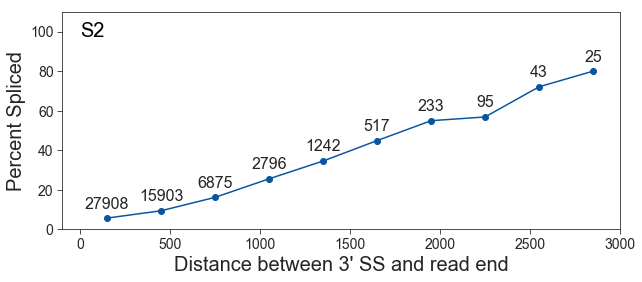

In [12]:
# SUPPLEMENTAL FIGURE 5F - S2 extended distance transcribed before splicing plots

# read in files
S2_1a_minimap2_splice_df = pd.read_table('/path/to/S2_1a_dm6_medIntrons_discarded_splice_df.txt', header=0)
S2_1b_minimap2_splice_df = pd.read_table('/path/to/S2_1b_dm6_medIntrons_discarded_splice_df.txt', header=0)
S2_2_minimap2_splice_df = pd.read_table('/path/to/S2_2_dm6_medIntrons_discarded_splice_df.txt', header=0)
S2_3_minimap2_splice_df = pd.read_table('/path/to/S2_3_dm6_medIntrons_discarded_splice_df.txt', header=0)

######### set variables for plot #########
window = 300
plot_min = 150
plot_max = 3150      

samples=['S2_1a','S2_1b','S2_2','S2_3']

######### get info for each sample #########
plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_minimap2_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window-1),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,splicedf_spliced,splicedf_unspliced,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','spliced_count','unspliced_count','percentSpliced']


######### get statistics for all samples #########
total = []

for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    sum_spliced = float(np.sum(plot_df[plot_df['range']==plot_range_high]['spliced_count']))
    sum_unspliced = float(np.sum(plot_df[plot_df['range']==plot_range_high]['unspliced_count']))
    count = sum_spliced + sum_unspliced
    percentSpliced = sum_spliced / (sum_spliced + sum_unspliced) * 100
    total.append([int(plot_range_middle), count, percentSpliced])

sum_plot_df = pd.DataFrame(total)
sum_plot_df.columns = ['range','count','percentSpliced']


######### plot mean and standard deviation for all samples #########

x = sum_plot_df['range'].values
y = sum_plot_df['percentSpliced'].values

fig, ax = plt.subplots(figsize=(10,4))

ax = plt.plot(x, y, color=sns.color_palette("Blues")[5])
plt.scatter(x, y, color=sns.color_palette("Blues")[5])

plt.ylabel("Percent Spliced", fontsize=20)
plt.xlabel("Distance between 3' SS and read end", fontsize=20)
plt.text(0, 105, 'S2', horizontalalignment='left', verticalalignment='top', fontsize=20, color='black')

count = sum_plot_df['count'].values 
for i in range(0,len(x)):
    plt.annotate(int(count[i]),xy=(x[i],y[i]+5),fontsize=16,horizontalalignment='center')

plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.xlim(-100,3000)
plt.ylim(0,110)

plt.savefig('/path/to/Supplemental_Figure_5D_S2_percent_spliced_by_distance_3kb.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [15]:
# SUPPLEMENTAL FIGURE 5I - distance transcribed before splicing plots without first or last introns

# upload file with information about all introns in dmel6
hg38_intron_info = pd.read_table('/path/to/annotation_files/hg38_all_intron_features.txt')
dm6_intron_info = pd.read_table('/path/to/annotation_files/dmel6_all_intron_features.txt')


# get first and last intron dictionaries
hg38_first_last_introns = get_first_last_introns(hg38_intron_info)
dm6_first_last_introns = get_first_last_introns(dm6_intron_info)


In [12]:
# upload files from directory
K562_1_splice_df = pd.read_table("/path/to/K562_1_hg38_medIntrons_discarded_splice_df.txt",header=0)
K562_2_splice_df = pd.read_table("/path/to/K562_2_hg38_medIntrons_discarded_splice_df.txt",header=0)
K562_3_splice_df = pd.read_table("/path/to/K562_3_hg38_medIntrons_discarded_splice_df.txt",header=0)
K562_4_splice_df = pd.read_table("/path/to/K562_4_hg38_medIntrons_discarded_splice_df.txt",header=0)
K562_5a_splice_df = pd.read_table("/path/to/K562_5a_hg38_medIntrons_discarded_splice_df.txt",header=0)
K562_5b_splice_df = pd.read_table("/path/to/K562_5b_hg38_medIntrons_discarded_splice_df.txt",header=0)
K562_5_splice_df = pd.concat([K562_5a_splice_df,K562_5b_splice_df],axis=0)

# upload files from directory
S2_1_splice_df = pd.read_table("/path/to/S2_1_dm6_medIntrons_discarded_splice_df.txt",header=0)
S2_2_splice_df = pd.read_table("/path/to/S2_2_dm6_medIntrons_discarded_splice_df.txt",header=0)
S2_3_splice_df = pd.read_table("/path/to/S2_3_dm6_medIntrons_discarded_splice_df.txt",header=0)

In [13]:
# human
K562_1_splice_df['chrom']='chr'+K562_1_splice_df['chrom']
K562_1_splice_df['intron_start']=K562_1_splice_df['intron_start']-1

K562_2_splice_df['chrom']='chr'+K562_2_splice_df['chrom']
K562_2_splice_df['intron_start']=K562_2_splice_df['intron_start']-1

K562_3_splice_df['chrom']='chr'+K562_3_splice_df['chrom']
K562_3_splice_df['intron_start']=K562_3_splice_df['intron_start']-1

K562_5a_splice_df['chrom']='chr'+K562_5a_splice_df['chrom']
K562_5a_splice_df['intron_start']=K562_5a_splice_df['intron_start']-1

K562_4_splice_df['chrom']='chr'+K562_4_splice_df['chrom']
K562_4_splice_df['intron_start']=K562_4_splice_df['intron_start']-1

K562_5b_splice_df['chrom']='chr'+K562_5b_splice_df['chrom']
K562_5b_splice_df['intron_start']=K562_5b_splice_df['intron_start']-1

K562_5_splice_df = pd.concat([K562_5a_splice_df, K562_5b_splice_df], axis=0)

# Drosophila
S2_1_splice_df['intron_start']=S2_1_splice_df['intron_start']-1
S2_2_splice_df['intron_start']=S2_2_splice_df['intron_start']-1
S2_3_splice_df['intron_start']=S2_3_splice_df['intron_start']-1


# get splice df files from middle introns

# human
K562_1_middleIntrons_splice_df = pd.merge(K562_1_splice_df,hg38_first_last_introns,on=['chrom','intron_start','intron_end','strand'], how='left')
K562_1_middleIntrons_splice_df = K562_1_middleIntrons_splice_df[K562_1_middleIntrons_splice_df['position']!='first'].reset_index(drop=True)
K562_1_middleIntrons_splice_df = K562_1_middleIntrons_splice_df[K562_1_middleIntrons_splice_df['position']!='last'].reset_index(drop=True)

K562_2_middleIntrons_splice_df = pd.merge(K562_2_splice_df,hg38_first_last_introns,on=['chrom','intron_start','intron_end','strand'], how='left')
K562_2_middleIntrons_splice_df = K562_2_middleIntrons_splice_df[K562_2_middleIntrons_splice_df['position']!='first'].reset_index(drop=True)
K562_2_middleIntrons_splice_df = K562_2_middleIntrons_splice_df[K562_2_middleIntrons_splice_df['position']!='last'].reset_index(drop=True)

K562_3_middleIntrons_splice_df = pd.merge(K562_3_splice_df,hg38_first_last_introns,on=['chrom','intron_start','intron_end','strand'], how='left')
K562_3_middleIntrons_splice_df = K562_3_middleIntrons_splice_df[K562_3_middleIntrons_splice_df['position']!='first'].reset_index(drop=True)
K562_3_middleIntrons_splice_df = K562_3_middleIntrons_splice_df[K562_3_middleIntrons_splice_df['position']!='last'].reset_index(drop=True)

K562_5_middleIntrons_splice_df = pd.merge(K562_5_splice_df,hg38_first_last_introns,on=['chrom','intron_start','intron_end','strand'], how='left')
K562_5_middleIntrons_splice_df = K562_5_middleIntrons_splice_df[K562_5_middleIntrons_splice_df['position']!='first'].reset_index(drop=True)
K562_5_middleIntrons_splice_df = K562_5_middleIntrons_splice_df[K562_5_middleIntrons_splice_df['position']!='last'].reset_index(drop=True)

K562_4_middleIntrons_splice_df = pd.merge(K562_4_splice_df,hg38_first_last_introns,on=['chrom','intron_start','intron_end','strand'], how='left')
K562_4_middleIntrons_splice_df = K562_4_middleIntrons_splice_df[K562_4_middleIntrons_splice_df['position']!='first'].reset_index(drop=True)
K562_4_middleIntrons_splice_df = K562_4_middleIntrons_splice_df[K562_4_middleIntrons_splice_df['position']!='last'].reset_index(drop=True)


# Drosophila
S2_1_middleIntrons_splice_df = pd.merge(S2_1_splice_df,dm6_first_last_introns,on=['chrom','intron_start','intron_end','strand'], how='left')
S2_1_middleIntrons_splice_df = S2_1_middleIntrons_splice_df[S2_1_middleIntrons_splice_df['position']!='first'].reset_index(drop=True)
S2_1_middleIntrons_splice_df = S2_1_middleIntrons_splice_df[S2_1_middleIntrons_splice_df['position']!='last'].reset_index(drop=True)

S2_2_middleIntrons_splice_df = pd.merge(S2_2_splice_df,dm6_first_last_introns,on=['chrom','intron_start','intron_end','strand'], how='left')
S2_2_middleIntrons_splice_df = S2_2_middleIntrons_splice_df[S2_2_middleIntrons_splice_df['position']!='first'].reset_index(drop=True)
S2_2_middleIntrons_splice_df = S2_2_middleIntrons_splice_df[S2_2_middleIntrons_splice_df['position']!='last'].reset_index(drop=True)

S2_3_middleIntrons_splice_df = pd.merge(S2_3_splice_df,dm6_first_last_introns,on=['chrom','intron_start','intron_end','strand'], how='left')
S2_3_middleIntrons_splice_df = S2_3_middleIntrons_splice_df[S2_3_middleIntrons_splice_df['position']!='first'].reset_index(drop=True)
S2_3_middleIntrons_splice_df = S2_3_middleIntrons_splice_df[S2_3_middleIntrons_splice_df['position']!='last'].reset_index(drop=True)


/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


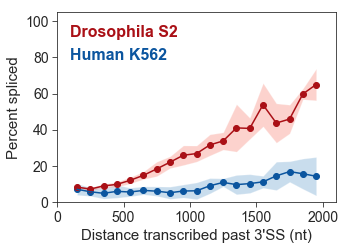

In [21]:
fig, ax = plt.subplots(figsize=(5,3.5))


######### set variables for plot #########
window = 100
plot_min = 100
plot_max = 2000      


######### get info for each sample - Human #########
samples=['K562_1','K562_2','K562_3','K562_4','K562_5']

plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_middleIntrons_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
human_N = np.sum(plot_df['count'])
human_plot_df = plot_df.copy()

######### get statistics for Human #########
mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

mean_plot_df = pd.DataFrame(mean)
mean_plot_df.columns = ['range','mean']
mean_plot_df['stdev'] = stdev

######### plot mean and standard deviation for Human #########

x = mean_plot_df['range'].values
y = mean_plot_df['mean'].values
err = mean_plot_df['stdev'].values

ax = plt.plot(x, y, color=sns.color_palette("Blues")[5])
plt.fill_between(x, y-err, y+err, facecolor=sns.color_palette("Blues")[4], interpolate=True, alpha=0.25)
plt.scatter(x, y, color=sns.color_palette("Blues")[5])


######### get info for each sample - Drosophila #########
samples=['S2_1','S2_2','S2_3']

plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_middleIntrons_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
drosophila_plot_df = plot_df.copy()
Drosophila_N = np.sum(plot_df['count'])

######### get statistics for all samples #########
mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

mean_plot_df = pd.DataFrame(mean)
mean_plot_df.columns = ['range','mean']
mean_plot_df['stdev'] = stdev

######### plot mean and standard deviation for all samples #########

x = mean_plot_df['range'].values
y = mean_plot_df['mean'].values
err = mean_plot_df['stdev'].values

ax = plt.plot(x, y, color=sns.color_palette("Reds")[5])
plt.fill_between(x, y-err, y+err, facecolor=sns.color_palette("Reds")[3], interpolate=True, alpha=0.25)
plt.scatter(x, y, color=sns.color_palette("Reds")[5])


plt.ylabel("Percent spliced", fontsize=15)
plt.xlabel("Distance transcribed past 3'SS (nt)", fontsize=15)
#plt.suptitle("Percent Spliced by Distance Transcribed", fontsize=15, y=0.95)
plt.text(100, 98, 'Drosophila S2', horizontalalignment='left', verticalalignment='top', fontsize=16, weight='bold', color=sns.color_palette("Reds")[5])
plt.text(100, 85, 'Human K562', horizontalalignment='left', verticalalignment='top', fontsize=16, weight='bold', color=sns.color_palette("Blues")[5])

plt.xticks([0,500,1000,1500,2000], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.xlim(0,2100)
plt.ylim(0,105)

plt.savefig('/path/to/Supplemental_Figure_5I_K562_S2_noFirst_noLast_introns_distance_spliced_plot.pdf',
            format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [22]:
Drosophila_N

26134

In [23]:
human_N

54465

In [25]:
human_plot_df.to_csv('/path/to/human_distance_transcribed_med_noFirstLast_plot_df.txt', sep='\t', header=True, index=False)
drosophila_plot_df.to_csv('/path/to/drosophila_distance_transcribed_med_noFirstLast_plot_df.txt', sep='\t', header=True, index=False)

In [3]:
# SUPPLEMENTAL FIGURE 5H - distance transcribed before splicing plots at different gene expression levels

# read in intron coordinate bed file
hg38_intron_df = pd.read_table('/path/to/annotation_files/NCBI_RefSeq_hg38_introns_parsed.bed',header=None,low_memory=False)
hg38_intron_df.columns = ['chrom','intron_start','intron_end','name','zero','strand']

# convert name to include both gene name and intron number
hg38_intron_df['name'] = hg38_intron_df['name'].apply(lambda x: '_'.join(x.split('_')[0:4]))

# modify and add columns for easier analysis
hg38_intron_df['chrom'] = hg38_intron_df['chrom'].apply(lambda x: 'chr'+str(x))
hg38_intron_df['gene'] = hg38_intron_df['name'].apply(lambda x: '_'.join(x.split('_')[0:2]))
hg38_intron_df['feature'] = hg38_intron_df['name'].apply(lambda x: x.split('_')[2])
hg38_intron_df['count'] = hg38_intron_df['name'].apply(lambda x: x.split('_')[3]).astype(int)
hg38_intron_df = hg38_intron_df.drop_duplicates(subset=['name']).reset_index(drop=True)


In [4]:
# get intron length
hg38_intron_lengths = get_intron_length(hg38_intron_df)

# read in PSI_counts bed file
hg38_4sUchr1_featureCounts_df = pd.read_table('/path/to/4sUchr_1_featureCount.txt')
hg38_4sUchr2_featureCounts_df = pd.read_table('/path/to/4sUchr_2_featureCount.txt')

# get PSI scores for each dataset
hg38_4sUchr1_RPKM_df = get_RPKM_df(hg38_intron_df, hg38_4sUchr1_featureCounts_df)
hg38_4sUchr2_RPKM_df = get_RPKM_df(hg38_intron_df, hg38_4sUchr2_featureCounts_df)

# merge PSI scores from each condition
hg38_4sUchrRPKM_values = pd.concat([hg38_4sUchr1_RPKM_df['name'],hg38_4sUchr1_RPKM_df['transcript_RPKM'],hg38_4sUchr2_RPKM_df['transcript_RPKM']], axis=1)
hg38_4sUchrRPKM_values.columns = ['name','RPKM_4sUchr1','RPKM_4sUchr2']

# read in PSI_counts bed file
hg38_tot1_featureCounts_df = pd.read_table('/path/to/tot_1_featureCount.txt')
hg38_tot2_featureCounts_df = pd.read_table('/paht/to/tot_2_featureCount.txt')

# get PSI scores for each dataset
hg38_tot1_RPKM_df = get_RPKM_df(hg38_intron_df, hg38_tot1_featureCounts_df)
hg38_tot2_RPKM_df = get_RPKM_df(hg38_intron_df, hg38_tot2_featureCounts_df)

# merge PSI scores from each condition
hg38_totRPKM_values = pd.concat([hg38_4sUchr1_RPKM_df['name'],hg38_4sUchr1_RPKM_df['transcript_RPKM'],hg38_4sUchr2_RPKM_df['transcript_RPKM']], axis=1)
hg38_totRPKM_values.columns = ['name','RPKM_tot1','RPKM_tot2']

# merge datasets to make a large dataset with all intron information
hg38_merge_df = pd.merge(hg38_intron_df, hg38_intron_lengths, how='left', on='name')
hg38_merge_df = pd.merge(hg38_merge_df, hg38_4sUchrRPKM_values, how='left', on='name')
hg38_merge_df = pd.merge(hg38_merge_df, hg38_totRPKM_values, how='left', on='name')

hg38_merge_df = hg38_merge_df.drop_duplicates(subset=['chrom','intron_start','intron_end','strand'])


In [5]:
# read in intron coordinate bed file
dmel_intron_df = pd.read_table('/path/to/annotation_files/dm6_RefSeq_introns_parsed.bed',header=None)
dmel_intron_df.columns = ['chrom','intron_start','intron_end','name','zero','strand']

# convert name to include both gene name and intron number
dmel_intron_df['name'] = dmel_intron_df['name'].apply(lambda x: '_'.join(x.split('_')[0:4]))

# modify and add columns for easier analysis
dmel_intron_df['chrom'] = dmel_intron_df['chrom'].apply(lambda x: 'chr'+str(x))
dmel_intron_df['gene'] = dmel_intron_df['name'].apply(lambda x: '_'.join(x.split('_')[0:2]))
dmel_intron_df['feature'] = dmel_intron_df['name'].apply(lambda x: x.split('_')[2])
dmel_intron_df['count'] = dmel_intron_df['name'].apply(lambda x: x.split('_')[3]).astype(int)
dmel_intron_df = dmel_intron_df.drop_duplicates(subset=['name']).reset_index(drop=True)


In [6]:
# get intron length
dmel_intron_lengths = get_intron_length(dmel_intron_df)

# read in featureCounts bed file
dmel_4sU_5min_featureCounts_df = pd.read_table('/path/to/DmelS2_4sUseq_5min_featureCount.txt')
dmel_4sU_10min_featureCounts_df = pd.read_table('/path/to/DmelS2_4sUseq_10min_featureCount.txt')
dmel_4sU_20min_featureCounts_df = pd.read_table('/path/to/DmelS2_4sUseq_20min_featureCount.txt')
dmel_tot_0min_featureCounts_df = pd.read_table('/path/to/DmelS2_total_RNAseq_featureCount.txt')

dmel_4sU_5min_RPKM_df = get_RPKM_df(dmel_intron_df, dmel_4sU_5min_featureCounts_df)
dmel_4sU_10min_RPKM_df = get_RPKM_df(dmel_intron_df, dmel_4sU_10min_featureCounts_df)
dmel_4sU_20min_RPKM_df = get_RPKM_df(dmel_intron_df, dmel_4sU_20min_featureCounts_df)
dmel_tot_0min_RPKM_df = get_RPKM_df(dmel_intron_df, dmel_tot_0min_featureCounts_df)

# merge PSI scores from each condition
dmel_RPKM_values = pd.concat([dmel_4sU_5min_RPKM_df['name'],dmel_4sU_5min_RPKM_df['transcript_RPKM'],dmel_4sU_10min_RPKM_df['transcript_RPKM'],dmel_4sU_20min_RPKM_df['transcript_RPKM'],dmel_tot_0min_RPKM_df['transcript_RPKM']], axis=1)
dmel_RPKM_values.columns = ['name','RPKM_5min_4sU','RPKM_10min_4sU','RPKM_20min_4sU','RPKM_tot_RNAseq']

### IMPORTANT NOTE: total RNA-seq dataset is not stranded, but analysis was performed assuming that it was

# merge datasets to make a large dataset with all intron information
dm6_merge_df = pd.merge(dmel_intron_df, dmel_intron_lengths, how='left', on='name')
dm6_merge_df = pd.merge(dmel_intron_df, dmel_RPKM_values, how='left', on='name')

dm6_merge_df = dm6_merge_df.drop_duplicates(subset=['chrom','intron_start','intron_end','strand'])


In [7]:
# upload files from directory
K562_1_splice_df = pd.read_table("/path/to/K562_1_hg38_medIntrons_discarded_splice_df.txt",header=0)
K562_2_splice_df = pd.read_table("/path/to/K562_2_hg38_medIntrons_discarded_splice_df.txt",header=0)
K562_3_splice_df = pd.read_table("/path/to/K562_3_hg38_medIntrons_discarded_splice_df.txt",header=0)
K562_5a_splice_df = pd.read_table("/path/to/K562_5a_hg38_medIntrons_discarded_splice_df.txt",header=0)
K562_4_splice_df = pd.read_table("/path/to/K562_4_hg38_medIntrons_discarded_splice_df.txt",header=0)
K562_5b_splice_df = pd.read_table("/path/to/K562_5b_hg38_medIntrons_discarded_splice_df.txt",header=0)
K562_5_splice_df = pd.concat([K562_5a_splice_df,K562_5b_splice_df],axis=0)

K562_1_splice_df['chrom']='chr'+K562_1_splice_df['chrom']
K562_2_splice_df['chrom']='chr'+K562_2_splice_df['chrom']
K562_3_splice_df['chrom']='chr'+K562_3_splice_df['chrom']
K562_5_splice_df['chrom']='chr'+K562_5_splice_df['chrom']
K562_4_splice_df['chrom']='chr'+K562_4_splice_df['chrom']

K562_1_splice_df['intron_start']=K562_1_splice_df['intron_start']-1
K562_2_splice_df['intron_start']=K562_2_splice_df['intron_start']-1
K562_3_splice_df['intron_start']=K562_3_splice_df['intron_start']-1
K562_5_splice_df['intron_start']=K562_5_splice_df['intron_start']-1
K562_4_splice_df['intron_start']=K562_4_splice_df['intron_start']-1

K562_1_splice_merge_df = pd.merge(K562_1_splice_df,hg38_merge_df,on=['chrom','intron_start','intron_end','strand']).reset_index(drop=True)
K562_2_splice_merge_df = pd.merge(K562_2_splice_df,hg38_merge_df,on=['chrom','intron_start','intron_end','strand']).reset_index(drop=True)
K562_3_splice_merge_df = pd.merge(K562_3_splice_df,hg38_merge_df,on=['chrom','intron_start','intron_end','strand']).reset_index(drop=True)
K562_5_splice_merge_df = pd.merge(K562_5_splice_df,hg38_merge_df,on=['chrom','intron_start','intron_end','strand']).reset_index(drop=True)
K562_4_splice_merge_df = pd.merge(K562_4_splice_df,hg38_merge_df,on=['chrom','intron_start','intron_end','strand']).reset_index(drop=True)

K562_splice_merge_df = pd.concat([K562_1_splice_merge_df,K562_2_splice_merge_df,K562_3_splice_merge_df,K562_5_splice_merge_df,K562_4_splice_merge_df]).reset_index(drop=True)


/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


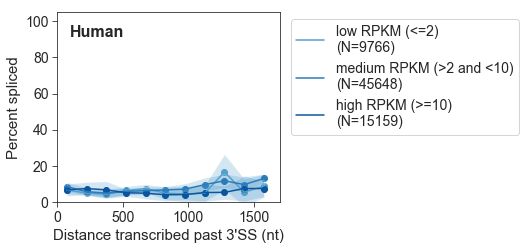

In [8]:
# split human dataframe files into expression levels
K562_1_low_splice_df = K562_1_splice_merge_df[K562_1_splice_merge_df['RPKM_tot1'] <= 2]
K562_1_med_splice_df = K562_1_splice_merge_df[(K562_1_splice_merge_df['RPKM_tot1'] > 2) & (K562_1_splice_merge_df['RPKM_tot1'] < 10)]
K562_1_high_splice_df = K562_1_splice_merge_df[K562_1_splice_merge_df['RPKM_tot1'] >= 10]

K562_2_low_splice_df = K562_2_splice_merge_df[K562_2_splice_merge_df['RPKM_tot1'] <= 2]
K562_2_med_splice_df = K562_2_splice_merge_df[(K562_2_splice_merge_df['RPKM_tot1'] > 2) & (K562_2_splice_merge_df['RPKM_tot1'] < 10)]
K562_2_high_splice_df = K562_2_splice_merge_df[K562_2_splice_merge_df['RPKM_tot1'] >= 10]

K562_3_low_splice_df = K562_3_splice_merge_df[K562_3_splice_merge_df['RPKM_tot1'] <= 2]
K562_3_med_splice_df = K562_3_splice_merge_df[(K562_3_splice_merge_df['RPKM_tot1'] > 2) & (K562_3_splice_merge_df['RPKM_tot1'] < 10)]
K562_3_high_splice_df = K562_3_splice_merge_df[K562_3_splice_merge_df['RPKM_tot1'] >= 10]

K562_4_low_splice_df = K562_4_splice_merge_df[K562_4_splice_merge_df['RPKM_tot1'] <= 2]
K562_4_med_splice_df = K562_4_splice_merge_df[(K562_4_splice_merge_df['RPKM_tot1'] > 2) & (K562_4_splice_merge_df['RPKM_tot1'] < 10)]
K562_4_high_splice_df = K562_4_splice_merge_df[K562_4_splice_merge_df['RPKM_tot1'] >= 10]

K562_5_low_splice_df = K562_5_splice_merge_df[K562_5_splice_merge_df['RPKM_tot1'] <= 2]
K562_5_med_splice_df = K562_5_splice_merge_df[(K562_5_splice_merge_df['RPKM_tot1'] > 2) & (K562_5_splice_merge_df['RPKM_tot1'] < 10)]
K562_5_high_splice_df = K562_5_splice_merge_df[K562_5_splice_merge_df['RPKM_tot1'] >= 10]


######### set variables for plot #########
window = 150
plot_min = 0
plot_max = 1650      

samples=['K562_1','K562_2','K562_3','K562_4','K562_5']

######### get info for each sample #########

### low expression
plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_low_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window)-1,int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
low_N = np.sum(plot_df['count'])
low_df = plot_df.copy()

mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

low_plot_df = pd.DataFrame(mean)
low_plot_df.columns = ['range','mean']
low_plot_df['stdev'] = stdev


### medium expression
plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_med_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window)-1,int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
med_N = np.sum(plot_df['count'])
med_df = plot_df.copy()

mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

med_plot_df = pd.DataFrame(mean)
med_plot_df.columns = ['range','mean']
med_plot_df['stdev'] = stdev


### high expression introns
plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_high_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window)-1,int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
high_N = np.sum(plot_df['count'])
high_df = plot_df.copy()

mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

high_plot_df = pd.DataFrame(mean)
high_plot_df.columns = ['range','mean']
high_plot_df['stdev'] = stdev

######### plot mean and standard deviation for all samples #########

x = low_plot_df['range'].values
low_y = low_plot_df['mean'].values
low_err = low_plot_df['stdev'].values
med_y = med_plot_df['mean'].values
med_err = med_plot_df['stdev'].values
high_y = high_plot_df['mean'].values
high_err = high_plot_df['stdev'].values

fig, ax = plt.subplots(figsize=(4,3.5))

ax = plt.plot(x, low_y, color=sns.color_palette("Blues")[3], label="low RPKM (<=2)\n(N="+str(low_N)+")")
plt.fill_between(x, low_y-low_err, low_y+low_err, facecolor=sns.color_palette("Blues")[3], interpolate=True, alpha=0.25)
plt.scatter(x, low_y, color=sns.color_palette("Blues")[3])

plt.plot(x, med_y, color=sns.color_palette("Blues")[4], label="medium RPKM (>2 and <10)\n(N="+str(med_N)+")")
plt.fill_between(x, med_y-med_err, med_y+med_err, facecolor=sns.color_palette("Blues")[3], interpolate=True, alpha=0.25)
plt.scatter(x, med_y, color=sns.color_palette("Blues")[4])

plt.plot(x, high_y, color=sns.color_palette("Blues")[5], label="high RPKM (>=10)\n(N="+str(high_N)+")")
plt.fill_between(x, high_y-high_err, high_y+high_err, facecolor=sns.color_palette("Blues")[3], interpolate=True, alpha=0.25)
plt.scatter(x, high_y, color=sns.color_palette("Blues")[5])

plt.ylabel("Percent spliced", fontsize=15)
plt.xlabel("Distance transcribed past 3'SS (nt)", fontsize=15)
#plt.suptitle("Percent Spliced by Distance Transcribed", fontsize=15, y=0.95)
plt.text(100, 98, 'Human', horizontalalignment='left', verticalalignment='top', fontsize=16, weight='bold')

plt.xticks([0,500,1000,1500,2000], fontsize=14)
plt.yticks([0,20,40,60,80,100], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
plt.legend(bbox_to_anchor=[2.1,1], fontsize=14)

plt.xlim(0,1700)
plt.ylim(0,105)

plt.savefig('/path/to/Supplemental_Figure_5H_K562_distance_spliced_byGeneRPKM_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [10]:
low_df.to_csv('/path/to/human_distance_transcribed_lowRPKM_plot_df.txt', sep='\t', header=True, index=False)
med_df.to_csv('/path/to/human_distance_transcribed_medRPKM_plot_df.txt', sep='\t', header=True, index=False)
high_df.to_csv('/path/to/human_distance_transcribed_highRPKM_plot_df.txt', sep='\t', header=True, index=False)

In [11]:
# upload files from directory
S2_1_splice_df = pd.read_table("/path/to/S2_1_dm6_medIntrons_discarded_splice_df.txt",header=0)
S2_2_splice_df = pd.read_table("/path/to/S2_2_dm6_medIntrons_discarded_splice_df.txt",header=0)
S2_3_splice_df = pd.read_table("/path/to/S2_3_dm6_medIntrons_discarded_splice_df.txt",header=0)

S2_1_splice_df['intron_start']=S2_1_splice_df['intron_start']-1
S2_2_splice_df['intron_start']=S2_2_splice_df['intron_start']-1
S2_3_splice_df['intron_start']=S2_3_splice_df['intron_start']-1

S2_1_splice_merge_df = pd.merge(S2_1_splice_df,dm6_merge_df,on=['chrom','intron_start','intron_end','strand']).reset_index(drop=True)
S2_2_splice_merge_df = pd.merge(S2_2_splice_df,dm6_merge_df,on=['chrom','intron_start','intron_end','strand']).reset_index(drop=True)
S2_3_splice_merge_df = pd.merge(S2_3_splice_df,dm6_merge_df,on=['chrom','intron_start','intron_end','strand']).reset_index(drop=True)

S2_splice_merge_df = pd.concat([S2_1_splice_merge_df,S2_2_splice_merge_df,S2_3_splice_merge_df]).reset_index(drop=True)


/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


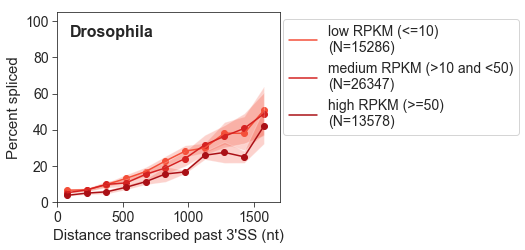

In [12]:
# split drosophila dataframe files into short and long introns
S2_1_low_splice_df = S2_1_splice_merge_df[S2_1_splice_merge_df['RPKM_tot_RNAseq'] <= 10]
S2_1_med_splice_df = S2_1_splice_merge_df[(S2_1_splice_merge_df['RPKM_tot_RNAseq'] > 10) & (S2_1_splice_merge_df['RPKM_tot_RNAseq'] < 50)]
S2_1_high_splice_df = S2_1_splice_merge_df[S2_1_splice_merge_df['RPKM_tot_RNAseq'] >= 50]

S2_2_low_splice_df = S2_2_splice_merge_df[S2_2_splice_merge_df['RPKM_tot_RNAseq'] <= 10]
S2_2_med_splice_df = S2_2_splice_merge_df[(S2_2_splice_merge_df['RPKM_tot_RNAseq'] > 10) & (S2_2_splice_merge_df['RPKM_tot_RNAseq'] < 50)]
S2_2_high_splice_df = S2_2_splice_merge_df[S2_2_splice_merge_df['RPKM_tot_RNAseq'] >= 50]

S2_3_low_splice_df = S2_3_splice_merge_df[S2_3_splice_merge_df['RPKM_tot_RNAseq'] <= 10]
S2_3_med_splice_df = S2_3_splice_merge_df[(S2_3_splice_merge_df['RPKM_tot_RNAseq'] > 10) & (S2_3_splice_merge_df['RPKM_tot_RNAseq'] < 50)]
S2_3_high_splice_df = S2_3_splice_merge_df[S2_3_splice_merge_df['RPKM_tot_RNAseq'] >= 50]


######### set variables for plot #########
window = 150
plot_min = 0
plot_max = 1650      

samples=['S2_1','S2_2','S2_3']

######### get info for each sample #########

### low expression
plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_low_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window)-1,int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
low_N = np.sum(plot_df['count'])
low_df = plot_df.copy()

mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

low_plot_df = pd.DataFrame(mean)
low_plot_df.columns = ['range','mean']
low_plot_df['stdev'] = stdev


### medium expression
plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_med_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window)-1,int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
med_N = np.sum(plot_df['count'])
med_df = plot_df.copy()

mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

med_plot_df = pd.DataFrame(mean)
med_plot_df.columns = ['range','mean']
med_plot_df['stdev'] = stdev


### high expression
plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_high_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window)-1,int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
high_N = np.sum(plot_df['count'])
high_df = plot_df.copy()

mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

high_plot_df = pd.DataFrame(mean)
high_plot_df.columns = ['range','mean']
high_plot_df['stdev'] = stdev

######### plot mean and standard deviation for all samples #########

x = low_plot_df['range'].values
low_y = low_plot_df['mean'].values
low_err = low_plot_df['stdev'].values
med_y = med_plot_df['mean'].values
med_err = med_plot_df['stdev'].values
high_y = high_plot_df['mean'].values
high_err = high_plot_df['stdev'].values

fig, ax = plt.subplots(figsize=(4,3.5))

ax = plt.plot(x, low_y, color=sns.color_palette("Reds")[3], label="low RPKM (<=10)\n(N="+str(low_N)+")")
plt.fill_between(x, low_y-low_err, low_y+low_err, facecolor=sns.color_palette("Reds")[3], interpolate=True, alpha=0.25)
plt.scatter(x, low_y, color=sns.color_palette("Reds")[3])

plt.plot(x, med_y, color=sns.color_palette("Reds")[4], label="medium RPKM (>10 and <50)\n(N="+str(med_N)+")")
plt.fill_between(x, med_y-med_err, med_y+med_err, facecolor=sns.color_palette("Reds")[3], interpolate=True, alpha=0.25)
plt.scatter(x, med_y, color=sns.color_palette("Reds")[4])

plt.plot(x, high_y, color=sns.color_palette("Reds")[5], label="high RPKM (>=50)\n(N="+str(high_N)+")")
plt.fill_between(x, high_y-high_err, high_y+high_err, facecolor=sns.color_palette("Reds")[3], interpolate=True, alpha=0.25)
plt.scatter(x, high_y, color=sns.color_palette("Reds")[5])

plt.ylabel("Percent spliced", fontsize=15)
plt.xlabel("Distance transcribed past 3'SS (nt)", fontsize=15)
#plt.suptitle("Percent Spliced by Distance Transcribed", fontsize=15, y=0.95)
plt.text(100, 98, 'Drosophila', horizontalalignment='left', verticalalignment='top', fontsize=16, weight='bold')

plt.xticks([0,500,1000,1500,2000], fontsize=14)
plt.yticks([0,20,40,60,80,100], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
plt.legend(bbox_to_anchor=[2.1,1], fontsize=14)

plt.xlim(0,1700)
plt.ylim(0,105)

plt.savefig('/path/to/Supplemental_Figure_5H_S2_distance_spliced_byGeneRPKM_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [13]:
low_df.to_csv('/path/to/drosophila_distance_transcribed_lowRPKM_plot_df.txt', sep='\t', header=True, index=False)
med_df.to_csv('/path/to/drosophila_distance_transcribed_medRPKM_plot_df.txt', sep='\t', header=True, index=False)
high_df.to_csv('/path/to/drosophila_distance_transcribed_highRPKM_plot_df.txt', sep='\t', header=True, index=False)

In [22]:
# SUPPLEMENTAL FIGURE 5J - terminal intron splicing plots separated by intron length

# upload files from directory
# these files were produced with the script nanoCOP_termination_df_datasets.ipynb

S2_1_termination_df = pd.read_table("/path/to/S2_1_dm6_termination_df.txt",header=0)
S2_2_termination_df = pd.read_table("/path/to/S2_2_dm6_termination_df.txt",header=0)
S2_3_termination_df = pd.read_table("/path/to/S2_3_dm6_termination_df.txt",header=0)


######### set variables for plot #########
polyA_min = -50
polyA_max = 50
post_min = 50      
post_max = 550     


######### get info for each K562 sample #########
plot_list = [] 

samples=['S2_1','S2_2','S2_3'] 
length='short'

for k in samples:
    name = '%s' % k # get name of sample
    df = eval('%s_termination_df' % k) # get termination file for this sample
    df = df[df['intron_length']<100]

    post_range = df[df['polyA_dist'].astype(int).between(post_min, post_max, inclusive=True)] 
    post_spliced = len(post_range[post_range['splice_status']=="YES"])
    post_unspliced = len(post_range[post_range['splice_status']=="NO"])

    if (post_spliced + post_unspliced) > 0: 
        post_percentSpliced = (float(post_spliced) / (float(post_spliced) + float(post_unspliced)))*100
        post_percentUnspliced = (float(post_unspliced) / (float(post_spliced) + float(post_unspliced)))*100
    elif (post_spliced + post_unspliced) == 0: 
        post_percentSpliced = 0.0
        post_percentUnspliced = 0.0
    
    post_percentSpliced = float("{0:.3f}".format(post_percentSpliced))
    post_percentUnspliced = float("{0:.3f}".format(post_percentUnspliced))

    plot_list.append([name, length, 'uncleaved', post_spliced, 'spliced', float(post_percentSpliced)])
    plot_list.append([name, length, 'uncleaved', post_unspliced, 'unspliced', float(post_percentUnspliced)])

    
    polyA_range = df[df['polyA_dist'].astype(int).between(polyA_min, polyA_max, inclusive=True)] 
    polyA_spliced = len(polyA_range[polyA_range['splice_status']=="YES"])
    polyA_unspliced = len(polyA_range[polyA_range['splice_status']=="NO"])
    
    if (polyA_spliced + polyA_unspliced) > 0: 
        polyA_percentSpliced = (float(polyA_spliced) / (float(polyA_spliced) + float(polyA_unspliced)))*100
        polyA_percentUnspliced = (float(polyA_unspliced) / (float(polyA_spliced) + float(polyA_unspliced)))*100
    elif (polyA_spliced + polyA_unspliced) == 0: 
        polyA_percentSpliced = 0.0
        polyA_percentUnspliced = 0.0
    
    polyA_percentSpliced = float("{0:.3f}".format(polyA_percentSpliced))
    polyA_percentUnspliced = float("{0:.3f}".format(polyA_percentUnspliced))
    
    plot_list.append([name, length, 'cleaved', polyA_spliced, 'spliced', float(polyA_percentSpliced)])
    plot_list.append([name, length, 'cleaved', polyA_unspliced, 'unspliced', float(polyA_percentUnspliced)])

    
short_plot_df = pd.DataFrame(plot_list)
short_plot_df.columns = ['name','length', 'position','count','splice_status','percent']



######### get info for each S2 sample #########
plot_list = [] 

samples=['S2_1','S2_2','S2_3'] 
length='long'

for k in samples:
    name = '%s' % k # get name of sample
    df = eval('%s_termination_df' % k) # get termination file for this sample
    df = df[df['intron_length']>300]
    
    post_range = df[df['polyA_dist'].astype(int).between(post_min, post_max, inclusive=True)] 
    post_spliced = len(post_range[post_range['splice_status']=="YES"])
    post_unspliced = len(post_range[post_range['splice_status']=="NO"])

    if (post_spliced + post_unspliced) > 0: 
        post_percentSpliced = (float(post_spliced) / (float(post_spliced) + float(post_unspliced)))*100
        post_percentUnspliced = (float(post_unspliced) / (float(post_spliced) + float(post_unspliced)))*100
    elif (post_spliced + post_unspliced) == 0: 
        post_percentSpliced = 0.0
        post_percentUnspliced = 0.0
    
    post_percentSpliced = float("{0:.3f}".format(post_percentSpliced))
    post_percentUnspliced = float("{0:.3f}".format(post_percentUnspliced))

    plot_list.append([name, length, 'uncleaved', post_spliced, 'spliced', float(post_percentSpliced)])
    plot_list.append([name, length, 'uncleaved', post_unspliced, 'unspliced', float(post_percentUnspliced)])

    
    polyA_range = df[df['polyA_dist'].astype(int).between(polyA_min, polyA_max, inclusive=True)] 
    polyA_spliced = len(polyA_range[polyA_range['splice_status']=="YES"])
    polyA_unspliced = len(polyA_range[polyA_range['splice_status']=="NO"])
    
    if (polyA_spliced + polyA_unspliced) > 0: 
        polyA_percentSpliced = (float(polyA_spliced) / (float(polyA_spliced) + float(polyA_unspliced)))*100
        polyA_percentUnspliced = (float(polyA_unspliced) / (float(polyA_spliced) + float(polyA_unspliced)))*100
    elif (polyA_spliced + polyA_unspliced) == 0: 
        polyA_percentSpliced = 0.0
        polyA_percentUnspliced = 0.0
    
    polyA_percentSpliced = float("{0:.3f}".format(polyA_percentSpliced))
    polyA_percentUnspliced = float("{0:.3f}".format(polyA_percentUnspliced))
    
    plot_list.append([name, length, 'cleaved', polyA_spliced, 'spliced', float(polyA_percentSpliced)])
    plot_list.append([name, length, 'cleaved', polyA_unspliced, 'unspliced', float(polyA_percentUnspliced)])

    
long_plot_df = pd.DataFrame(plot_list)
long_plot_df.columns = ['name','length', 'position','count','splice_status','percent']


# merge plot dataframes
plot_df = pd.concat([short_plot_df,long_plot_df])


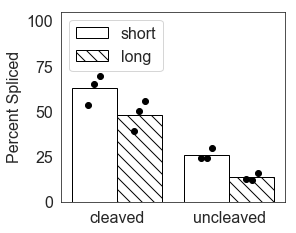

In [25]:

######### plot mean and standard deviation for all samples #########

spliced_plot_df = plot_df[plot_df['splice_status']=='spliced']

fig, ax = plt.subplots(figsize=(4,3.5))

ax = sns.barplot(x='position', y='percent', hue='length', data=spliced_plot_df, ci=None,
                order=['cleaved','uncleaved'], edgecolor = ['black','black'], fill=False)

# Define some hatches
hatches = ['','','\\\\','\\\\']

# Loop over the bars
for i,thisbar in enumerate(ax.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])


short_uncleaved = spliced_plot_df[(spliced_plot_df['length']=='short') & (spliced_plot_df['position']=='uncleaved')]
ax.plot(-0.25, short_cleaved.iloc[0]['percent'], "o", color='black', markersize=6)
ax.plot(-0.2, short_cleaved.iloc[1]['percent'], "o", color='black', markersize=6)
ax.plot(-0.15, short_cleaved.iloc[2]['percent'], "o", color='black', markersize=6)

long_uncleaved = spliced_plot_df[(spliced_plot_df['length']=='long') & (spliced_plot_df['position']=='uncleaved')]
ax.plot(0.15, long_cleaved.iloc[0]['percent'], "o", color='black', markersize=6)
ax.plot(0.2, long_cleaved.iloc[1]['percent'], "o", color='black', markersize=6)
ax.plot(0.25, long_cleaved.iloc[2]['percent'], "o", color='black', markersize=6)

short_cleaved = spliced_plot_df[(spliced_plot_df['length']=='short') & (spliced_plot_df['position']=='cleaved')]
ax.plot(0.75, short_uncleaved.iloc[0]['percent'], "o", color='black', markersize=6)
ax.plot(0.8, short_uncleaved.iloc[1]['percent'], "o", color='black', markersize=6)
ax.plot(0.85, short_uncleaved.iloc[2]['percent'], "o", color='black', markersize=6)

long_cleaved = spliced_plot_df[(spliced_plot_df['length']=='long') & (spliced_plot_df['position']=='cleaved')]
ax.plot(1.15, long_uncleaved.iloc[0]['percent'], "o", color='black', markersize=6)
ax.plot(1.2, long_uncleaved.iloc[1]['percent'], "o", color='black', markersize=6)
ax.plot(1.25, long_uncleaved.iloc[2]['percent'], "o", color='black', markersize=6)


plt.ylabel("Percent Spliced", fontsize=16)
plt.xlabel("", fontsize=18, labelpad=10)
#plt.xlabel("Position of the read 3'end", fontsize=18, labelpad=10)
#plt.suptitle("Splicing status of terminal introns", fontsize=20)

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)

plt.tick_params(axis='both', direction='out', length=5, width=1)

plt.ylim(0,105)
plt.legend(loc=2, fontsize=16)

plt.savefig('/path/to/Supplemental_Figure_5F_terminal_intron_splicing_bylength.pdf',
            format='pdf', dpi=300, bbox_inches='tight')
            
plt.show()


In [3]:
# SUPPLEMENTAL FIGURE 5K - Alternative introns by size

# Load Drosophila intron annotation
dm6_intron_df = pd.read_table('/path/to/annotation_files/dm6_RefSeq_introns_parsed_wiAltRNAseqMISO.txt', sep='\t')
dm6_intron_df = dm6_intron_df[dm6_intron_df['gene'].str.startswith('NM')]


In [4]:
# Load Human intron annotation
hg38_intron_df = pd.read_table('/path/to/annotation_files/hg38_RefSeq_introns_parsed_wiAltRNAseqMISO.v2.txt', sep='\t')
hg38_intron_df = hg38_intron_df[hg38_intron_df['gene'].str.startswith('NM')].reset_index()


In [5]:
# Calculate length
dm6_intron_df['length'] = np.log10(dm6_intron_df['end'] - dm6_intron_df['start'])
hg38_intron_df['length'] = np.log10(hg38_intron_df['end'] - hg38_intron_df['start'])


In [6]:
# Add a single column (YES/NO/OTHER) for MISO annotation
dm6_intron_df['MISO'] = 'Constitutive'

dm6_intron_df.loc[(dm6_intron_df['SE_MISO'] == 'YES') |
                (dm6_intron_df['A5SS_MISO'] == 'YES') |
                (dm6_intron_df['A3SS_MISO'] == 'YES') |
                (dm6_intron_df['MXE_MISO'] == 'YES'),'MISO'] = 'Alternative'


# Add a single column (YES/NO/OTHER) for combined annotation
dm6_intron_df['COMBINED'] = 'Other'

dm6_intron_df.loc[(dm6_intron_df['alternative_gtf'] == 'YES') &
                ((dm6_intron_df['SE_MISO'] == 'YES') |
                (dm6_intron_df['A5SS_MISO'] == 'YES') |
                (dm6_intron_df['A3SS_MISO'] == 'YES') |
                (dm6_intron_df['MXE_MISO'] == 'YES')),'COMBINED'] = 'Alternative'

dm6_intron_df.loc[(dm6_intron_df['alternative_gtf'] == 'NO') &
                ((dm6_intron_df['SE_MISO'] == 'NO') &
                (dm6_intron_df['A5SS_MISO'] == 'NO') &
                (dm6_intron_df['A3SS_MISO'] == 'NO') &
                (dm6_intron_df['MXE_MISO'] == 'NO')),'COMBINED'] = 'Constitutive'


dm6_intron_df['ANNOTATION'] = 'Constitutive'
dm6_intron_df.loc[dm6_intron_df['alternative_gtf'] == 'YES','ANNOTATION'] = 'Alternative'

In [7]:
# Reorganize the dataframe for plotting
dm6_intron_df_plot = dm6_intron_df.melt(id_vars=['name','length'], value_vars=['ANNOTATION', 'MISO','COMBINED'],
                         var_name='category', value_name='intron_type')

In [8]:
# Add a single column (YES/NO/OTHER) for MISO annotation
hg38_intron_df['MISO'] = 'Constitutive'

hg38_intron_df.loc[(hg38_intron_df['SE_MISO'] == 'YES') |
                (hg38_intron_df['A5SS_MISO'] == 'YES') |
                (hg38_intron_df['A3SS_MISO'] == 'YES') |
                (hg38_intron_df['MXE_MISO'] == 'YES'),'MISO'] = 'Alternative'

# Add a single column (YES/NO/OTHER) for combined annotation
hg38_intron_df['COMBINED'] = 'Other'

hg38_intron_df.loc[(hg38_intron_df['alternative_gtf'] == 'YES') &
                ((hg38_intron_df['SE_MISO'] == 'YES') |
                (hg38_intron_df['A5SS_MISO'] == 'YES') |
                (hg38_intron_df['A3SS_MISO'] == 'YES') |
                (hg38_intron_df['MXE_MISO'] == 'YES')),'COMBINED'] = 'Alternative'

hg38_intron_df.loc[(hg38_intron_df['alternative_gtf'] == 'NO') &
                ((hg38_intron_df['SE_MISO'] == 'NO') &
                (hg38_intron_df['A5SS_MISO'] == 'NO') &
                (hg38_intron_df['A3SS_MISO'] == 'NO') &
                (hg38_intron_df['MXE_MISO'] == 'NO')),'COMBINED'] = 'Constitutive'

hg38_intron_df['ANNOTATION'] = 'Constitutive'
hg38_intron_df.loc[hg38_intron_df['alternative_gtf'] == 'YES','ANNOTATION'] = 'Alternative'

In [9]:
# Reorganize the dataframe for plotting
hg38_intron_df_plot = hg38_intron_df.melt(id_vars=['name','length'], value_vars=['ANNOTATION', 'MISO','COMBINED'],
                         var_name='category', value_name='intron_type')

In [10]:
# Extract the relevant info for Drosophila (COMBINED classification)
dm6_intron_df_plot2 = dm6_intron_df_plot[(dm6_intron_df_plot['category'] == 'COMBINED') &
                                        (dm6_intron_df_plot['intron_type'] != 'Other')].reset_index(drop=True)

# Extract the relevant info for Human (MISO classification)
hg38_intron_df_plot2 = hg38_intron_df_plot[hg38_intron_df_plot['category'] == 'MISO'].reset_index(drop=True)

# Add a column for species
dm6_intron_df_plot2['species'] = 'Drosophila'
hg38_intron_df_plot2['species'] = 'Human'

# Concatenate the two
intron_df_plot2 = pd.concat([dm6_intron_df_plot2,hg38_intron_df_plot2],axis=0)


In [14]:
# Read Drosophila files and calculate intron length
# These datasets were produced in the script nanoCOP_Figure_2_plots.ipynb
S2_1_intron_alt_splice_df = pd.read_table('/path/to/S2_1_intron_alt_splice_df.txt', header=0)
S2_1_intron_const_splice_df = pd.read_table('/path/to/S2_1_intron_const_splice_df.txt',header=0)
S2_2_intron_alt_splice_df = pd.read_table('/path/to/S2_2_intron_alt_splice_df.txt', header=0)
S2_2_intron_const_splice_df = pd.read_table('/path/to/S2_2_intron_const_splice_df.txt', header=0)
S2_3_intron_alt_splice_df = pd.read_table('/path/to/S2_3_intron_alt_splice_df.txt', header=0)
S2_3_intron_const_splice_df = pd.read_table('/path/to/S2_3_intron_const_splice_df.txt', header=0)

S2_1_intron_alt_splice_df['intron_length'] = S2_1_intron_alt_splice_df['end'] - S2_1_intron_alt_splice_df['start']
S2_1_intron_const_splice_df['intron_length'] = S2_1_intron_const_splice_df['end'] - S2_1_intron_const_splice_df['start']
S2_2_intron_alt_splice_df['intron_length'] = S2_2_intron_alt_splice_df['end'] - S2_2_intron_alt_splice_df['start']
S2_2_intron_const_splice_df['intron_length'] = S2_2_intron_const_splice_df['end'] - S2_2_intron_const_splice_df['start']
S2_3_intron_alt_splice_df['intron_length'] = S2_3_intron_alt_splice_df['end'] - S2_3_intron_alt_splice_df['start']
S2_3_intron_const_splice_df['intron_length'] = S2_3_intron_const_splice_df['end'] - S2_3_intron_const_splice_df['start']

S2_intron_alt_splice_df = pd.concat([S2_1_intron_alt_splice_df,S2_2_intron_alt_splice_df,S2_3_intron_alt_splice_df])
S2_intron_const_splice_df = pd.concat([S2_1_intron_const_splice_df,S2_2_intron_const_splice_df,S2_3_intron_const_splice_df])

In [13]:
# Read Human files and calculate intron length
# These datasets were produced in the script for Figure 2
K562_1_intron_alt_splice_df = pd.read_table('/path/to/K562_1_intron_alt_splice_df.txt', header=0)
K562_1_intron_const_splice_df = pd.read_table('/path/to/K562_1_intron_const_splice_df.txt',header=0)
K562_2_intron_alt_splice_df = pd.read_table('/path/to/K562_2_intron_alt_splice_df.txt', header=0)
K562_2_intron_const_splice_df = pd.read_table('/path/to/K562_2_intron_const_splice_df.txt', header=0)
K562_3_intron_alt_splice_df = pd.read_table('/path/to/K562_3_intron_alt_splice_df.txt', header=0)
K562_3_intron_const_splice_df = pd.read_table('/path/to/K562_3_intron_const_splice_df.txt', header=0)
K562_4_intron_alt_splice_df = pd.read_table('/path/to/K562_4_intron_alt_splice_df.txt', header=0)
K562_4_intron_const_splice_df = pd.read_table('/path/to/K562_4_intron_const_splice_df.txt', header=0)
K562_5_intron_alt_splice_df = pd.read_table('/path/to/K562_5_intron_alt_splice_df.txt', header=0)
K562_5_intron_const_splice_df = pd.read_table('/path/to/K562_5_intron_const_splice_df.txt', header=0)

K562_1_intron_alt_splice_df['intron_length'] = K562_1_intron_alt_splice_df['end'] - K562_1_intron_alt_splice_df['start']
K562_1_intron_const_splice_df['intron_length'] = K562_1_intron_const_splice_df['end'] - K562_1_intron_const_splice_df['start']
K562_2_intron_alt_splice_df['intron_length'] = K562_2_intron_alt_splice_df['end'] - K562_2_intron_alt_splice_df['start']
K562_2_intron_const_splice_df['intron_length'] = K562_2_intron_const_splice_df['end'] - K562_2_intron_const_splice_df['start']
K562_3_intron_alt_splice_df['intron_length'] = K562_3_intron_alt_splice_df['end'] - K562_3_intron_alt_splice_df['start']
K562_3_intron_const_splice_df['intron_length'] = K562_3_intron_const_splice_df['end'] - K562_3_intron_const_splice_df['start']
K562_4_intron_alt_splice_df['intron_length'] = K562_4_intron_alt_splice_df['end'] - K562_4_intron_alt_splice_df['start']
K562_4_intron_const_splice_df['intron_length'] = K562_4_intron_const_splice_df['end'] - K562_4_intron_const_splice_df['start']
K562_5_intron_alt_splice_df['intron_length'] = K562_5_intron_alt_splice_df['end'] - K562_5_intron_alt_splice_df['start']
K562_5_intron_const_splice_df['intron_length'] = K562_5_intron_const_splice_df['end'] - K562_5_intron_const_splice_df['start']

K562_intron_alt_splice_df = pd.concat([K562_1_intron_alt_splice_df,K562_2_intron_alt_splice_df,K562_3_intron_alt_splice_df,K562_5_intron_alt_splice_df,K562_4_intron_alt_splice_df])
K562_intron_const_splice_df = pd.concat([K562_1_intron_const_splice_df,K562_2_intron_const_splice_df,K562_3_intron_const_splice_df,K562_5_intron_const_splice_df,K562_4_intron_const_splice_df])

/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


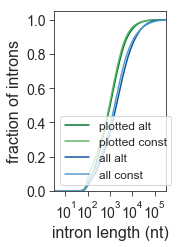

In [19]:
fig, ax = plt.subplots(figsize=(2,3.3))

plotted_alt_intron_lengths = np.log10(K562_intron_alt_splice_df['intron_length'].values)
plotted_const_intron_lengths = np.log10(K562_intron_const_splice_df['intron_length'].values)
hg38_alt_intron_lengths = hg38_intron_df_plot2[hg38_intron_df_plot2['intron_type'] == 'Alternative']['length']
hg38_const_intron_lengths = hg38_intron_df_plot2[hg38_intron_df_plot2['intron_type'] == 'Constitutive']['length']

ax = sns.distplot(plotted_alt_intron_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Greens")[5], label='plotted alt')
sns.distplot(plotted_const_intron_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Greens")[3], label='plotted const')
sns.distplot(hg38_alt_intron_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Blues")[5], label='all alt')
sns.distplot(hg38_const_intron_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Blues")[3], label='all const')


x_labels = ["$\mathregular{10^{1}}$","$\mathregular{10^{2}}$","$\mathregular{10^{3}}$","$\mathregular{10^{4}}$","$\mathregular{10^{5}}$"]
plt.xticks([1,2,3,4,5], x_labels, fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(0.5,5.5)

ax.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
ax.set_ylabel("fraction of introns", fontsize=16)
ax.set_xlabel("intron length (nt)", fontsize=16)
ax.legend(loc=3, fontsize=12)

plt.savefig('/path/to/Supplemental_Figure_5G_alt_vs_const_intronLength_Human.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()

/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


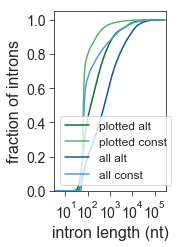

In [20]:
fig, ax = plt.subplots(figsize=(2,3.3))

plotted_alt_intron_lengths = np.log10(S2_intron_alt_splice_df['intron_length'].values)
plotted_const_intron_lengths = np.log10(S2_intron_const_splice_df['intron_length'].values)
dm6_alt_intron_lengths = dm6_intron_df_plot2[dm6_intron_df_plot2['intron_type'] == 'Alternative']['length']
dm6_const_intron_lengths = dm6_intron_df_plot2[dm6_intron_df_plot2['intron_type'] == 'Constitutive']['length']

ax = sns.distplot(plotted_alt_intron_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Greens")[5], label='plotted alt')
sns.distplot(plotted_const_intron_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Greens")[3], label='plotted const')
sns.distplot(dm6_alt_intron_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Blues")[5], label='all alt')
sns.distplot(dm6_const_intron_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Blues")[3], label='all const')


x_labels = ["$\mathregular{10^{1}}$","$\mathregular{10^{2}}$","$\mathregular{10^{3}}$","$\mathregular{10^{4}}$","$\mathregular{10^{5}}$"]
plt.xticks([1,2,3,4,5], x_labels, fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(0.5,5.5)

ax.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
ax.set_ylabel("fraction of introns", fontsize=16)
ax.set_xlabel("intron length (nt)", fontsize=16)
ax.legend(loc=3, fontsize=12)

plt.savefig('/path/to/Supplemental_Figure_5G_alt_vs_const_intronLength_Drosophila.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [3]:
# SUPPLEMETNAL FIGURE 5G - length distribution of introns in distance transcribed before splicing plots

# upload files from directory
K562_1_splice_df = pd.read_table("/path/to/K562_1_hg38_medIntrons_discarded_splice_df.txt",header=0)
K562_2_splice_df = pd.read_table("/path/to/K562_2_hg38_medIntrons_discarded_splice_df.txt",header=0)
K562_3_splice_df = pd.read_table("/path/to/K562_3_hg38_medIntrons_discarded_splice_df.txt",header=0)
K562_5a_splice_df = pd.read_table("/path/to/K562_5a_hg38_medIntrons_discarded_splice_df.txt",header=0)
K562_4_splice_df = pd.read_table("/path/to/K562_4_hg38_medIntrons_discarded_splice_df.txt",header=0)
K562_5b_splice_df = pd.read_table("/path/to/K562_5b_hg38_medIntrons_discarded_splice_df.txt",header=0)
K562_5_splice_df = pd.concat([K562_5a_splice_df,K562_5b_splice_df],axis=0)

K562_splice_df = pd.concat([K562_1_splice_df,K562_2_splice_df,K562_3_splice_df,K562_4_splice_df,K562_5_splice_df],axis=0)
K562_splice_df = K562_splice_df[(K562_splice_df['dist_from_3SS']>100) & (K562_splice_df['dist_from_3SS']<2000)]
K562_splice_df = K562_splice_df[K562_splice_df['splice_status']!='UNDETERMINED']
K562_splice_df['intron_length'] = K562_splice_df['intron_end']-K562_splice_df['intron_start']


In [6]:
# upload file with information about all introns in hg38 or dmel6
hg38_intron_info = pd.read_table('/path/to/annotation_files/hg38_all_intron_features.txt')
hg38_intron_info = hg38_intron_info[['chrom','start','end','name','intron_length','strand']]
hg38_intron_info = hg38_intron_info.drop_duplicates(subset=['chrom','start','end','strand']).reset_index(drop=True)

# get reads per gene for ONT sequencing datasets
# upload gene information as a BedTool for parsing
genes_df = pd.read_table('/path/to/annotation_files/NCBI_RefSeq_hg38_genes_parsed.bed',header=None)
genes_df = genes_df.drop([6,7,8,9,10,11], axis=1) # drop irrelevant columns from dataframe
genes_df.columns = ['chrom','start','end','transcript','gene_length','strand']
genes_df['gene_length'] = genes_df['end']-genes_df['start']
genes_df['transcript'] = genes_df.apply(lambda row: row['transcript'].split('.')[0], axis=1)
genes_df = genes_df.drop_duplicates(subset=['chrom','start','end','strand']).reset_index(drop=True)

# get list of gene names for all transcripts
names_df = pd.read_table('/path/to/annotation_files/hg38_UCSC_refGene_names.txt', header=None)
names_df.columns = ['gene','transcript']

genes_names_merge = pd.merge(genes_df, names_df, on=['transcript'], how='left')
genes_names_merge['gene'] = genes_names_merge.apply(lambda row: name_missing_genes(row) , axis=1)
genes_names_merge = genes_names_merge.sort_values(by='gene_length', ascending=False).reset_index(drop=True)
genes_names_merge = genes_names_merge.drop_duplicates(subset=['gene'], keep='first').reset_index(drop=True)

genes_names_merge = genes_names_merge.sort_values(by=['chrom','start','end'], ascending=True).reset_index(drop=True)
#genes_names_merge['chrom'] = 'chr'+genes_names_merge['chrom']

# create a bed file for all unique genes
gene_bed = BedTool.from_dataframe(genes_names_merge)

# Upload merged BAM file from all K562 replicates
K562_bamFile = pybedtools.BedTool('/path/to/all_K562_hg38_minimap2_uniq_sort.bam')
K562_bedFile = K562_bamFile.bam_to_bed()

K562_coverage = gene_bed.coverage(K562_bedFile, s=True, counts=True) 
K562_df = K562_coverage.to_dataframe() # covert to dataframe
K562_df.columns =['chrom','start','end','transcript','score','strand','gene','count'] # label columns
K562_df = K562_df.drop_duplicates(subset=['chrom','start','end','strand']).reset_index(drop=True) # remove duplicate gene coords


In [7]:
# get introns from genes with top 10% expression
K562_genes = K562_df.copy()
K562_genes['expression'] = K562_genes['count']/(K562_genes['end']-K562_genes['start'])
K562_genes = K562_genes[K562_genes['expression']>K562_genes['expression'].quantile(q=0.9)].reset_index(drop=True)

hg38_introns = hg38_intron_info.copy()
hg38_introns['gene'] = hg38_introns.apply(lambda row: str(row['name'].split("_")[0])+'_'+str(row['name'].split("_")[1].split(".")[0]) , axis=1)

K562_introns = hg38_introns[hg38_introns.apply(lambda row: row['gene'] in set(K562_genes['transcript']) , axis=1)].reset_index(drop=True)


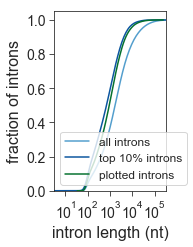

In [16]:

fig, ax = plt.subplots(figsize=(2,3.3))

hg38_intron_lengths = np.log10(hg38_intron_info['intron_length'].values)
K562_dist_intron_lengths = np.log10(K562_splice_df['intron_length'].values)
K562_introns = np.log10(K562_introns['intron_length'].values)

ax = sns.distplot(hg38_intron_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Blues")[3], bins=np.max(hg38_intron_info['intron_length']), label='all introns')
sns.distplot(K562_introns, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Blues")[5], bins=np.max(hg38_intron_info['intron_length']), label='top 10% introns')
sns.distplot(K562_dist_intron_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Greens")[5], bins=np.max(hg38_intron_info['intron_length']), label='plotted introns')

x_labels = ["$\mathregular{10^{1}}$","$\mathregular{10^{2}}$","$\mathregular{10^{3}}$","$\mathregular{10^{4}}$","$\mathregular{10^{5}}$"]
plt.xticks([1,2,3,4,5], x_labels, fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(0.5,5.5)

ax.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
ax.set_ylabel("fraction of introns", fontsize=16)
ax.set_xlabel("intron length (nt)", fontsize=16)
ax.legend(loc=3, fontsize=12)

plt.savefig('/path/to/Supplemental_Figure_5G_K562_distspliced_intron_length_cumdist_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [17]:

# upload files from directory
S2_1_splice_df = pd.read_table("/path/to/S2_1_dm6_medIntrons_discarded_splice_df.txt",header=0)
S2_2_splice_df = pd.read_table("/path/to/S2_2_dm6_medIntrons_discarded_splice_df.txt",header=0)
S2_3_splice_df = pd.read_table("/path/to/S2_3_dm6_medIntrons_discarded_splice_df.txt",header=0)

S2_splice_df = pd.concat([S2_1_splice_df,S2_2_splice_df,S2_3_splice_df],axis=0)
S2_splice_df = S2_splice_df[(S2_splice_df['dist_from_3SS']>100) & (S2_splice_df['dist_from_3SS']<2000)]
S2_splice_df = S2_splice_df[S2_splice_df['splice_status']!='UNDETERMINED']
S2_splice_df['intron_length'] = S2_splice_df['intron_end']-S2_splice_df['intron_start']


In [18]:
# upload file with information about all introns in hg38 or dmel6
dm6_intron_info = pd.read_table('/path/to/annotation_files/dmel6_all_intron_features.txt')
dm6_intron_info = dm6_intron_info[['chrom','start','end','name','intron_length','strand']]
dm6_intron_info = dm6_intron_info.drop_duplicates(subset=['chrom','start','end','strand']).reset_index(drop=True)

# get reads per gene for ONT sequencing datasets
# upload gene information as a BedTool for parsing
genes_df = pd.read_table('/path/to/annotation_files/dm6_RefSeq_genes_parsed.bed',header=None)
genes_df.columns = ['chrom','start','end','transcript','gene_length','strand']
genes_df['chrom'] = "chr"+genes_df['chrom']
genes_df['gene_length'] = genes_df['end']-genes_df['start']
genes_df['transcript'] = genes_df.apply(lambda row: row['transcript'].split('.')[0], axis=1)
genes_df = genes_df.drop_duplicates(subset=['chrom','start','end','strand']).reset_index(drop=True)

# get list of gene names for all transcripts
names_df = pd.read_table('/path/to/annotation_files/dm6_RefSeq_names_parsed.txt', header=None)
names_df.columns = ['gene','transcript']

genes_names_merge = pd.merge(genes_df, names_df, on=['transcript'], how='left')
genes_names_merge['gene'] = genes_names_merge.apply(lambda row: name_missing_genes(row) , axis=1)
genes_names_merge = genes_names_merge.sort_values(by='gene_length', ascending=False).reset_index(drop=True)
genes_names_merge = genes_names_merge.drop_duplicates(subset=['gene'], keep='first').reset_index(drop=True)

genes_names_merge = genes_names_merge.sort_values(by=['chrom','start','end'], ascending=True).reset_index(drop=True)

# create a bed file for all unique genes
gene_bed = BedTool.from_dataframe(genes_names_merge)

# get S2 ONT coverage information for both replicates
S2_bamFile = pybedtools.BedTool('/path/to/all_S2_dmel6_minimap2_uniq_sort.bam')

S2_bedFile = S2_bamFile.bam_to_bed()

# get number of reads that overlap each gene feature
S2_coverage = gene_bed.coverage(S2_bedFile, s=True, counts=True) 

# make a dataframe from coverage file
S2_df = S2_coverage.to_dataframe() # covert to dataframe
S2_df.columns =['chrom','start','end','transcript','score','strand','gene','count'] # label columns
S2_df = S2_df.drop_duplicates(subset=['chrom','start','end','strand']).reset_index(drop=True) # remove duplicate gene coords


In [19]:
# get introns from genes with top 10% expression
S2_genes = S2_df.copy()

S2_genes['expression'] = S2_genes['count']/(S2_genes['end']-S2_genes['start'])
S2_genes = S2_genes[S2_genes['expression']>S2_genes['expression'].quantile(q=0.9)].reset_index(drop=True)


dm6_introns = dm6_intron_info.copy()
dm6_introns['gene'] = dm6_introns.apply(lambda row: str(row['name'].split("_")[0])+'_'+str(row['name'].split("_")[1].split(".")[0]) , axis=1)

S2_introns = dm6_introns[dm6_introns.apply(lambda row: row['gene'] in set(S2_genes['transcript']) , axis=1)].reset_index(drop=True)


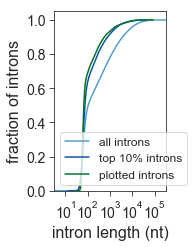

In [20]:

fig, ax = plt.subplots(figsize=(2,3.3))

hg38_intron_lengths = np.log10(dm6_intron_info['intron_length'].values)
K562_dist_intron_lengths = np.log10(S2_splice_df['intron_length'].values)
K562_introns = np.log10(S2_introns['intron_length'].values)

ax = sns.distplot(hg38_intron_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Blues")[3], bins=np.max(hg38_intron_info['intron_length']), label='all introns')
sns.distplot(K562_introns, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Blues")[5], bins=np.max(hg38_intron_info['intron_length']), label='top 10% introns')
sns.distplot(K562_dist_intron_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Greens")[5], bins=np.max(hg38_intron_info['intron_length']), label='plotted introns')

x_labels = ["$\mathregular{10^{1}}$","$\mathregular{10^{2}}$","$\mathregular{10^{3}}$","$\mathregular{10^{4}}$","$\mathregular{10^{5}}$"]
plt.xticks([1,2,3,4,5], x_labels, fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(0.5,5.5)

ax.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
ax.set_ylabel("fraction of introns", fontsize=16)
ax.set_xlabel("intron length (nt)", fontsize=16)
ax.legend(loc=3, fontsize=12)

plt.savefig('/path/to/Supplemental_Figure_5G_S2_distspliced_intron_length_cumdist_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()
